In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import random


In [205]:
import torch.distributions as tch
import torch

In [206]:
gama = tch.gamma.Gamma(1, 2)

In [207]:
x = gama.sample()

In [208]:
x.item()

0.22151152789592743

In [209]:
np.exp(gama.log_prob(x.item()).item())

1.2841848083826104

# Rat Data Set

In [111]:
data1 = pd.read_csv("/Users/brianxiang/Downloads/data.final.2024.Q3.csv")

## Standard MCMC

### Data and Set Up

We are measuring tumor incidence in rats across 15 different experiments. Our data consists of $n_i = $ the number of rats in each experiment $i$ and $y_i = $ the number of those rats that had tumors.

We design a Beta-Binomial hierarchical model as follows:

$$y_i \sim Bin(n_i, \theta_i)$$

$$\theta_i \sim Beta(\alpha, \beta)$$

with noninformative prior $p(\alpha, \beta) \propto 1$.

This gives us the following conditional distributions:

$$\theta_i | y_i, \alpha, \beta \sim Beta(y_i + \alpha, n_i - y_i + \beta)$$

$$p(\alpha, \beta | y, \theta) \propto (\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)})^{15}\prod_{i = 1}^{15}\theta_i^\alpha(1 - \theta_i)^\beta \Rightarrow$$

$$\ln(p(\alpha, \beta | y, \theta)) \propto -15\ln(\frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)}) + \sum_{i = 1}^{15} \alpha \ln(\theta_i) + \beta \ln(1 - \theta_i)$$

We use a Gibbs sampler with a Metropolis step to sample from the joint posterior distribution $\theta, \alpha, \beta | y$ using normal proposal distributions $\alpha^* \sim Norm(\alpha^{t - 1}. \nu_\alpha), \beta^* \sim Norm(\beta^{t - 1}. \nu_\beta)$ for each iteration $t$ with tuning parameter $\nu_\alpha, \nu_\beta$.



In [112]:
def logab(theta, a, b):
    if a <= 0 or b <= 0:
        return -float("inf")
    return -15 * np.log(scipy.special.beta(a, b)) + np.sum(a * np.log(theta) + b * np.log(1 - theta))

In [113]:
def chain(n, y, theta_init, alpha_init, beta_init, numsamp, atuning = 0.3, btuning = 1.1):
    accept = 0
    reject = 0
    
    theta_samps = np.zeros((numsamp, 15))
    alpha_samps = np.zeros(numsamp)
    beta_samps = np.zeros(numsamp)
    
    theta_samps[0] = theta_init
    alpha_samps[0] = alpha_init
    beta_samps[0] = beta_init
    
    for i in range(1, numsamp):        
        alpha_prop = np.random.normal(alpha_samps[i - 1], atuning)
        beta_prop = np.random.normal(beta_samps[i - 1], btuning)
        log_r = logab(theta_samps[i - 1], alpha_prop, beta_prop) - logab(theta_samps[i - 1], alpha_samps[i - 1], beta_samps[i - 1])
        log_u = np.log(random.uniform(0, 1))
        
        if log_u <= log_r:
            alpha_samps[i] = alpha_prop
            beta_samps[i] = beta_prop
            accept = accept + 1
            
        else:
            alpha_samps[i] = alpha_samps[i - 1]
            beta_samps[i] = beta_samps[i - 1]
            reject = reject + 1
            
        theta_samps[i] = np.random.beta(y + alpha_samps[i], n - y + beta_samps[i], 15)
        
    print("Acceptance Rate: ", accept/(accept + reject))
    
    return theta_samps, alpha_samps, beta_samps


### Initial Values and Tuning Parameters

We use two chain with inital values:

$$\alpha_1^{(0)} = 1, \beta_1^{(0)} = 2, \theta_{1i}^{(0)} \sim Beta(y_i + 1, n_i - y_i + 2)$$

and 

$$\alpha_2^{(0)} = 20, \beta_2^{(0)} = 50, \theta_{2i}^{(0)} \sim Beta(y_i + 20, n_i - y_i + 50)$$

We use tuning parameters $\nu_\alpha = 0.3, \nu_\beta = 1.1$ which were determined based on the acceptance rate ($\sim$75%).

In [114]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

theta_samps1, alpha_samps1, beta_samps1 = chain(n, y, theta_1, a_1, b_1, 10000)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

theta_samps2, alpha_samps2, beta_samps2 = chain(n, y, theta_2, a_2, b_2, 10000)

Acceptance Rate:  0.7641764176417641
Acceptance Rate:  0.7681768176817682


In [115]:
chain1_df = pd.DataFrame(np.vstack((np.linspace(1, 10000, 10000), alpha_samps1, beta_samps1, theta_samps1.T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10', 'theta_11', 'theta_12', 'theta_13', 'theta_14', 'theta_15'))
chain2_df = pd.DataFrame(np.vstack((np.linspace(1, 10000, 10000), alpha_samps2, beta_samps2, theta_samps2.T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10', 'theta_11', 'theta_12', 'theta_13', 'theta_14', 'theta_15'))

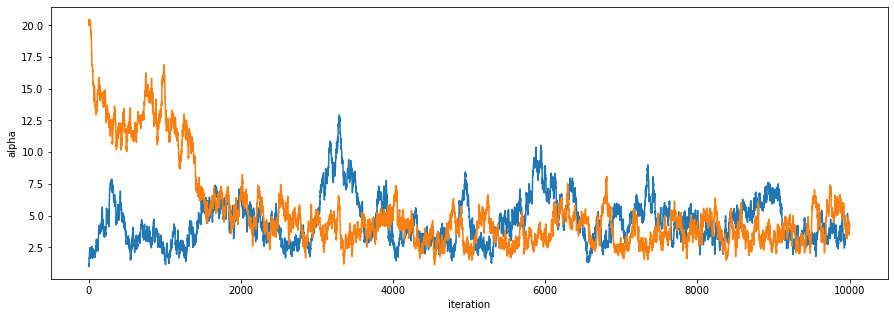

In [116]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

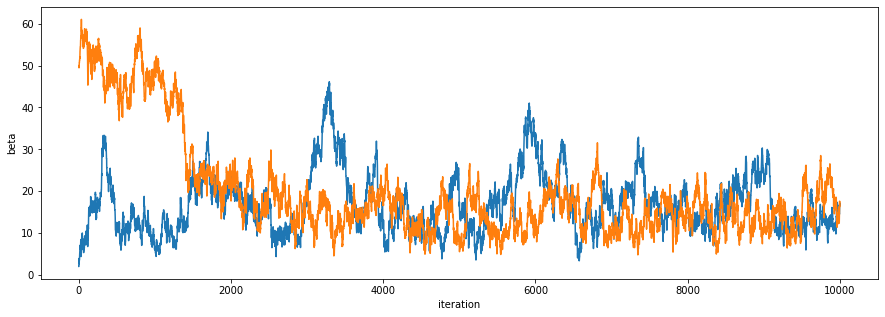

In [117]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

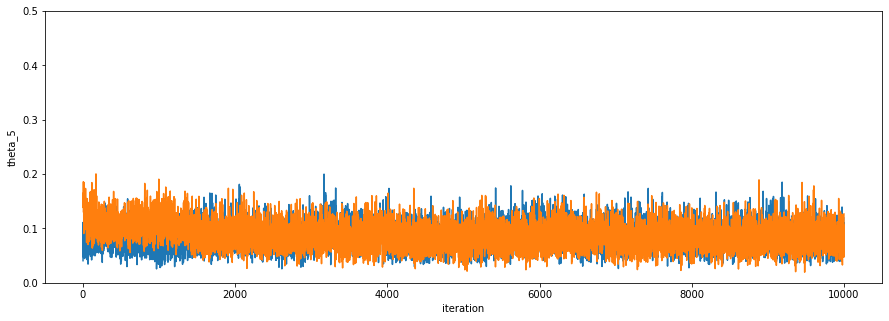

In [118]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta_5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta_5', ax = ax)

ax.set_ylim(0, 0.5)
plt.show()

## Unbiased MCMC

In [119]:
def loga(alpha, beta, theta):
    if alpha <= 0:
        return -float("inf")
    return 15 * (np.log(scipy.special.gamma(alpha + beta)) - np.log(scipy.special.gamma(alpha))) + alpha * np.sum(np.log(theta))

In [120]:
def logb(alpha, beta, theta):
    if beta <= 0:
        return -float("inf")
    return 15 * (np.log(scipy.special.gamma(alpha + beta)) - np.log(scipy.special.gamma(beta))) + beta * np.sum(np.log(1 - theta))

In [121]:
def sample_couple(x, samp_func, p, q):
    wx = random.uniform(0, p(x))
    if wx <= q(x):
        return x, 1
    else:
        y_star = samp_func()
        wy = random.uniform(0, q(y_star))
        
        while wy <= p(y_star):
            y_star = samp_func()
            wy = random.uniform(0, q(y_star))
            
        return y_star, 0

In [122]:
def ar_prop(prev, prop, log_p):
    log_u = np.log(random.uniform(0, 1))
    log_r = log_p(prop) - log_p(prev)
    
    if log_u <= log_r:
        return prop
    else:
        return prev

### Current Working Version with Automatic Convergence Detection

In [130]:
def unbiased_metropolis1(n, y, theta_init1, alpha_init1, beta_init1, theta_init2, alpha_init2, beta_init2, numsamp, atuning = 0.3, btuning = 1.1, lag = 1):
    theta_samps1 = np.zeros((numsamp, 15))
    alpha_samps1 = np.zeros(numsamp)
    beta_samps1 = np.zeros(numsamp)
    
    theta_samps2 = np.zeros((numsamp - lag, 15))
    alpha_samps2 = np.zeros(numsamp - lag)
    beta_samps2 = np.zeros(numsamp - lag)
    
    theta_samps1[0] = theta_init1
    alpha_samps1[0] = alpha_init1
    beta_samps1[0] = beta_init1
    
    theta_samps2[0] = theta_init2
    alpha_samps2[0] = alpha_init2
    beta_samps2[0] = beta_init2
    
    cnta = 0
    cntb = 0
    cnttheta = np.zeros(15)
    
    converge = False
        
    for i in range(1, numsamp):
        alpha_prop1 = np.random.normal(alpha_samps1[i - 1], atuning)
        alpha_samps1[i] = ar_prop(alpha_samps1[i - 1], alpha_prop1, lambda x: loga(x, beta_samps1[i - 1], theta_samps1[i - 1]))
            
        beta_prop1 = np.random.normal(beta_samps1[i - 1], btuning)
        beta_samps1[i] = ar_prop(beta_samps1[i - 1], beta_prop1, lambda x: logb(alpha_samps1[i], x, theta_samps1[i - 1]))
            
        theta_samps1[i] = np.random.beta(y + alpha_samps1[i], n - y + beta_samps1[i], 15)
            
        if lag < i:
            alpha_prop2, aind = sample_couple(alpha_prop1, 
                                        lambda : np.random.normal(alpha_samps2[i - lag - 1], atuning),
                                        lambda x1: scipy.stats.norm.pdf(x1, alpha_samps1[i - 1], atuning),
                                        lambda x2: scipy.stats.norm.pdf(x2, alpha_samps2[i - lag - 1], atuning)
                                        )
            alpha_samps2[i - lag] = ar_prop(alpha_samps2[i - lag - 1], alpha_prop2, lambda x: loga(x, beta_samps2[i - lag - 1], theta_samps2[i - lag - 1]))
            if aind == 0:
                cnta = 0
            else:
                cnta += aind

            beta_prop2, bind = sample_couple(beta_prop1, 
                                        lambda : np.random.normal(beta_samps2[i - lag - 1], btuning),
                                        lambda x1: scipy.stats.norm.pdf(x1, beta_samps1[i - 1], btuning),
                                        lambda x2: scipy.stats.norm.pdf(x2, beta_samps2[i - lag - 1], btuning)
                                        )
            beta_samps2[i - lag] = ar_prop(beta_samps2[i - lag - 1], beta_prop2, lambda x: logb(alpha_samps2[i - lag], x, theta_samps2[i - lag - 1]))
            if bind == 0:
                cntb = 0
            else:
                cntb += bind
                            
            theta_samps2[i - lag] = np.random.beta(y + alpha_samps2[i - lag], n - y + beta_samps2[i - lag], 15)

        if cnta > 20 and cntb > 20:
            if not converge:
                print(i)
                converge = True
    if not converge:
        print("did not converge")
        
    return theta_samps1, alpha_samps1, beta_samps1, theta_samps2, alpha_samps2, beta_samps2


In [263]:
def prob_theta(y, n, alpha, beta, theta):
    return np.prod(np.power(theta, y + alpha - 1) * np.power((1 - theta), n - y + beta - 1))

In [279]:
def unbiased_metropolis2(n, y, theta_init1, alpha_init1, beta_init1, theta_init2, alpha_init2, beta_init2, numsamp, atuning = 0.3, btuning = 1.1, lag = 1):
    theta_samps1 = np.zeros((numsamp, 15))
    alpha_samps1 = np.zeros(numsamp)
    beta_samps1 = np.zeros(numsamp)
    
    theta_samps2 = np.zeros((numsamp - lag, 15))
    alpha_samps2 = np.zeros(numsamp - lag)
    beta_samps2 = np.zeros(numsamp - lag)
    
    theta_samps1[0] = theta_init1
    alpha_samps1[0] = alpha_init1
    beta_samps1[0] = beta_init1
    
    theta_samps2[0] = theta_init2
    alpha_samps2[0] = alpha_init2
    beta_samps2[0] = beta_init2
    
    cnta = 0
    cntb = 0
    cnttheta = 0
    
    converge = False
        
    for i in range(1, numsamp):
        alpha_prop1 = np.random.normal(alpha_samps1[i - 1], atuning)
        alpha_samps1[i] = ar_prop(alpha_samps1[i - 1], alpha_prop1, lambda x: loga(x, beta_samps1[i - 1], theta_samps1[i - 1]))
            
        beta_prop1 = np.random.normal(beta_samps1[i - 1], btuning)
        beta_samps1[i] = ar_prop(beta_samps1[i - 1], beta_prop1, lambda x: logb(alpha_samps1[i], x, theta_samps1[i - 1]))
            
        theta_prop1 = np.random.beta(y + alpha_samps1[i], n - y + beta_samps1[i], 15)
        theta_samps1[i] = theta_prop1
            
        if lag < i:
            alpha_prop2, aind = sample_couple(alpha_prop1, 
                                        lambda : np.random.normal(alpha_samps2[i - lag - 1], atuning),
                                        lambda x1: scipy.stats.norm.pdf(x1, alpha_samps1[i - 1], atuning),
                                        lambda x2: scipy.stats.norm.pdf(x2, alpha_samps2[i - lag - 1], atuning)
                                        )
            alpha_samps2[i - lag] = ar_prop(alpha_samps2[i - lag - 1], alpha_prop2, lambda x: loga(x, beta_samps2[i - lag - 1], theta_samps2[i - lag - 1]))
            if aind == 0:
                cnta = 0
            else:
                cnta += aind

            beta_prop2, bind = sample_couple(beta_prop1, 
                                        lambda : np.random.normal(beta_samps2[i - lag - 1], btuning),
                                        lambda x1: scipy.stats.norm.pdf(x1, beta_samps1[i - 1], btuning),
                                        lambda x2: scipy.stats.norm.pdf(x2, beta_samps2[i - lag - 1], btuning)
                                        )
            beta_samps2[i - lag] = ar_prop(beta_samps2[i - lag - 1], beta_prop2, lambda x: logb(alpha_samps2[i - lag], x, theta_samps2[i - lag - 1]))
            if bind == 0:
                cntb = 0
            else:
                cntb += bind
                                   
            theta_prop2, tind = sample_couple(theta_prop1,
                                        lambda : np.random.beta(y + alpha_samps2[i - lag], n - y + beta_samps2[i - lag], 15),
                                        lambda x1: prob_theta(y, n, alpha_samps1[i], beta_samps1[i], x1),
                                        lambda x2: prob_theta(y, n, alpha_samps2[i - lag], beta_samps2[i - lag], x2)
                                        )
            if tind == 0:
                cnttheta = 0
            else:
                cnttheta += tind
            theta_samps2[i - lag] = theta_prop2
        
        if cnta > 20 and cntb > 20 and cnttheta > 20:
            if not converge:
                print(i)
                converge = True
    if not converge:
        print("did not converge")
        
    return theta_samps1, alpha_samps1, beta_samps1, theta_samps2, alpha_samps2, beta_samps2


In [286]:
def logabt(n, y, alpha, beta, theta):
    if alpha <= 0 or beta <= 0:
        return -float("inf")
    else:
        return 15 * (np.log(scipy.special.gamma(alpha + beta)) - np.log(scipy.special.gamma(alpha)) - np.log(scipy.special.gamma(beta))) + (y + alpha - 1) * np.sum(np.log(theta)) + (n - y + beta - 1) * np.sum(np.log(1 - theta))

In [ ]:
def unbiased_metropolis3(n, y, theta_init1, alpha_init1, beta_init1, theta_init2, alpha_init2, beta_init2, numsamp, atuning = 0.3, btuning = 1.1, lag = 1):
    theta_samps1 = np.zeros((numsamp, 15))
    alpha_samps1 = np.zeros(numsamp)
    beta_samps1 = np.zeros(numsamp)
    
    theta_samps2 = np.zeros((numsamp - lag, 15))
    alpha_samps2 = np.zeros(numsamp - lag)
    beta_samps2 = np.zeros(numsamp - lag)
    
    theta_samps1[0] = theta_init1
    alpha_samps1[0] = alpha_init1
    beta_samps1[0] = beta_init1
    
    theta_samps2[0] = theta_init2
    alpha_samps2[0] = alpha_init2
    beta_samps2[0] = beta_init2
    
    cnta = 0
    cntb = 0
    cnttheta = 0
    
    converge = False
        
    for i in range(1, numsamp):
        alpha_prop1 = np.random.normal(alpha_samps1[i - 1], atuning)
        beta_prop1 = np.random.normal(beta_samps1[i - 1], btuning)
        theta_prop1 = np.random.beta(y + alpha_prop1, n - y + beta_prop1, 15)

        alpha_samps1[i] = ar_prop(alpha_samps1[i - 1], alpha_prop1, lambda x, y, z: logabt(x, y, theta_samps1[i - 1]))
            
            
        theta_prop1 = np.random.beta(y + alpha_samps1[i], n - y + beta_samps1[i], 15)
        theta_samps1[i] = theta_prop1
            
        if lag < i:
            alpha_prop2, aind = sample_couple(alpha_prop1, 
                                        lambda : np.random.normal(alpha_samps2[i - lag - 1], atuning),
                                        lambda x1: scipy.stats.norm.pdf(x1, alpha_samps1[i - 1], atuning),
                                        lambda x2: scipy.stats.norm.pdf(x2, alpha_samps2[i - lag - 1], atuning)
                                        )
            alpha_samps2[i - lag] = ar_prop(alpha_samps2[i - lag - 1], alpha_prop2, lambda x: loga(x, beta_samps2[i - lag - 1], theta_samps2[i - lag - 1]))
            if aind == 0:
                cnta = 0
            else:
                cnta += aind

            beta_prop2, bind = sample_couple(beta_prop1, 
                                        lambda : np.random.normal(beta_samps2[i - lag - 1], btuning),
                                        lambda x1: scipy.stats.norm.pdf(x1, beta_samps1[i - 1], btuning),
                                        lambda x2: scipy.stats.norm.pdf(x2, beta_samps2[i - lag - 1], btuning)
                                        )
            beta_samps2[i - lag] = ar_prop(beta_samps2[i - lag - 1], beta_prop2, lambda x: logb(alpha_samps2[i - lag], x, theta_samps2[i - lag - 1]))
            if bind == 0:
                cntb = 0
            else:
                cntb += bind
                                   
            theta_prop2, tind = sample_couple(theta_prop1,
                                        lambda : np.random.beta(y + alpha_samps2[i - lag], n - y + beta_samps2[i - lag], 15),
                                        lambda x1: prob_theta(y, n, alpha_samps1[i], beta_samps1[i], x1),
                                        lambda x2: prob_theta(y, n, alpha_samps2[i - lag], beta_samps2[i - lag], x2)
                                        )
            if tind == 0:
                cnttheta = 0
            else:
                cnttheta += tind
            theta_samps2[i - lag] = theta_prop2
        
        if cnta > 20 and cntb > 20 and cnttheta > 20:
            if not converge:
                print(i)
                converge = True
    if not converge:
        print("did not converge")
        
    return theta_samps1, alpha_samps1, beta_samps1, theta_samps2, alpha_samps2, beta_samps2


In [131]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

theta_samps1, alpha_samps1, beta_samps1, theta_samps2, alpha_samps2, beta_samps2 = unbiased_metropolis1(n, y, theta_1, a_1, b_1, theta_2, a_2, b_2, 15000)

1883


In [280]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

theta_samps1, alpha_samps1, beta_samps1, theta_samps2, alpha_samps2, beta_samps2 = unbiased_metropolis2(n, y, theta_1, a_1, b_1, theta_2, a_2, b_2, 15000)

865


In [132]:
chain1_df = pd.DataFrame(np.vstack((np.linspace(1, 10000, 10000), alpha_samps1[1:10001], beta_samps1[1:10001], theta_samps1[1:10001].T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10', 'theta_11', 'theta_12', 'theta_13', 'theta_14', 'theta_15'))
chain2_df = pd.DataFrame(np.vstack((np.linspace(1, 10000, 10000), alpha_samps2[:10000], beta_samps2[:10000], theta_samps2[:10000].T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10', 'theta_11', 'theta_12', 'theta_13', 'theta_14', 'theta_15'))

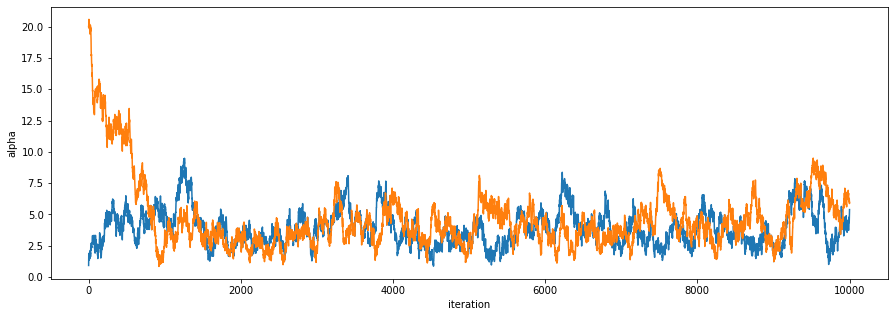

In [133]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

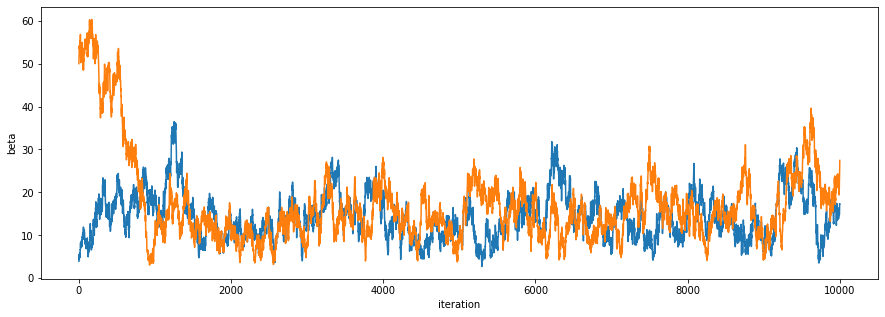

In [134]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

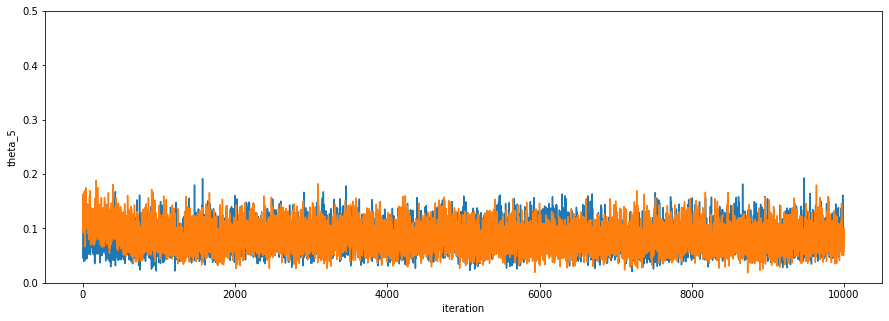

In [128]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta_5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta_5', ax = ax)

ax.set_ylim(0, 0.5)
plt.show()

# Neighborhood Crime Data

Determine average (across years) rate of crime in 10 different neighborhoods ($\mu_1, \mu_2, \ldots \mu_{10}$). 

$$y_{ij} \sim Norm(\mu_i, \sigma^2)$$

$$\mu_{i} \sim Norm(\mu_0, \tau^2)$$

$$p(\mu_0) \propto 1$$

$$p(\sigma^2) \propto 1/\sigma^2$$

$$p(\tau^2) \propto 1/\tau$$

Normal-Normal HM

In [211]:
data2 = pd.read_csv("/Users/brianxiang/Downloads/data.final.2024.Q1.csv")

In [212]:
df = data2.pivot(index = 'year', columns = 'nbd', values = 'y')

In [169]:
def standard_gibbs(df, mu_init1, mu0_init1, tau_init1, sigma_init1, mu_init2, mu0_init2, tau_init2, sigma_init2, numsamp):
    mu_samps1 = np.zeros((numsamp, 10))
    mu0_samps1 = np.zeros(numsamp)
    tau_samps1 = np.zeros(numsamp)
    sigma_samps1 = np.zeros(numsamp)
    
    mu_samps2 = np.zeros((numsamp, 10))
    mu0_samps2 = np.zeros(numsamp)
    tau_samps2 = np.zeros(numsamp)
    sigma_samps2 = np.zeros(numsamp)
    
    mu_samps1[0] = mu_init1
    mu0_samps1[0] = mu0_init1
    tau_samps1[0] = tau_init1
    sigma_samps1[0] = sigma_init1
    
    mu_samps2[0] = mu_init2
    mu0_samps2[0] = mu0_init2
    tau_samps2[0] = tau_init2
    sigma_samps2[0] = sigma_init2
    
    for i in range(1, numsamp):
        mu0_samps1[i] = np.random.normal(np.mean(mu_samps1[i - 1]), np.sqrt(tau_samps1[i - 1]/10))
        tau_samps1[i] = scipy.stats.invgamma.rvs(a = 9/2, scale = np.sum(np.power(mu_samps1[i - 1] - mu0_samps1[i], 2)) / 2)
        sigma_samps1[i] = scipy.stats.invgamma.rvs(a = 75, scale = np.sum(np.sum(np.power(df - mu_samps1[i - 1], 2))) / 2)

        mean1 = 15 * df.mean(axis = 0).to_numpy() / sigma_samps1[i] + mu0_samps1[i] / tau_samps1[i]
        variance1 = 15 / sigma_samps1[i] + 1 / tau_samps1[i]
        mu_samps1[i] = np.random.normal(mean1 / variance1, np.sqrt(1 / variance1), 10)
        
        mu0_samps2[i] = np.random.normal(np.mean(mu_samps2[i - 1]), np.sqrt(tau_samps2[i - 1]/10))
        tau_samps2[i] = scipy.stats.invgamma.rvs(a = 9/2, scale = np.sum(np.power(mu_samps2[i - 1] - mu0_samps2[i], 2)) / 2)
        sigma_samps2[i] = scipy.stats.invgamma.rvs(a = 75, scale = np.sum(np.sum(np.power(df - mu_samps2[i - 1], 2))) / 2)

        mean2 = 15 * df.mean(axis = 0).to_numpy() / sigma_samps2[i] + mu0_samps2[i] / tau_samps2[i]
        variance2 = 15 / sigma_samps2[i] + 1 / tau_samps2[i]
        mu_samps2[i] = np.random.normal(mean2 / variance2, np.sqrt(1 / variance2), 10)

    return mu_samps1, mu0_samps1, tau_samps1, sigma_samps1, mu_samps2, mu0_samps2, tau_samps2, sigma_samps2
    
    

In [176]:
mu0_init1 = 300
sigma_init1 = 200
tau_init1 = 150

mean1 = 15 * df.mean(axis = 0) / 200 + 300 / 150
variance1 = 15 / 200 + 1 / 150
mu_init1 = np.random.normal(mean1 / variance1, np.sqrt(1 / variance1), 10)

mu0_init2 = 5
sigma_init2 = 10
tau_init2 = 2

mean2 = 15 * df.mean(axis = 0) / 10 + 5 / 2
variance2 = 15 / 10 + 1 / 2
mu_init2 = np.random.normal(mean2 / variance2, np.sqrt(1 / variance2), 10)

mu_samps1, mu0_samps1, tau_samps1, sigma_samps1, mu_samps2, mu0_samps2, tau_samps2, sigma_samps2 = standard_gibbs(df, mu_init1, mu0_init1, tau_init1, sigma_init1, mu_init2, mu0_init2, tau_init2, sigma_init2, 150)


In [177]:
chain1_df = pd.DataFrame(np.vstack((np.linspace(1, 100, 100), mu0_samps1[1:101], sigma_samps1[1:101], tau_samps1[1:101], mu_samps1[1:101].T)).T, columns = ('iteration', 'mu0', 'tau', 'sigma', 'mu1', 'mu2', 'mu3', 'mu4', 'mu5', 'mu6', 'mu7', 'mu8', 'mu9', 'mu10'))
chain2_df = pd.DataFrame(np.vstack((np.linspace(1, 100, 100), mu0_samps2[:100], sigma_samps2[:100], tau_samps2[:100], mu_samps2[:100].T)).T, columns = ('iteration', 'mu0', 'tau', 'sigma', 'mu1', 'mu2', 'mu3', 'mu4', 'mu5', 'mu6', 'mu7', 'mu8', 'mu9', 'mu10'))

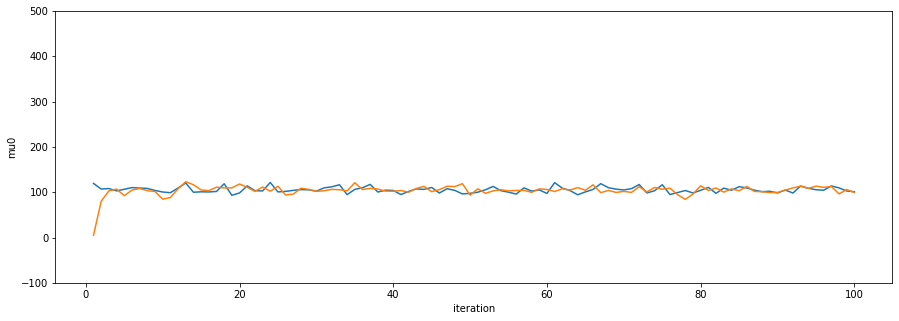

In [178]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'mu0', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'mu0', ax = ax)

ax.set_ylim(-100, 500)
plt.show()

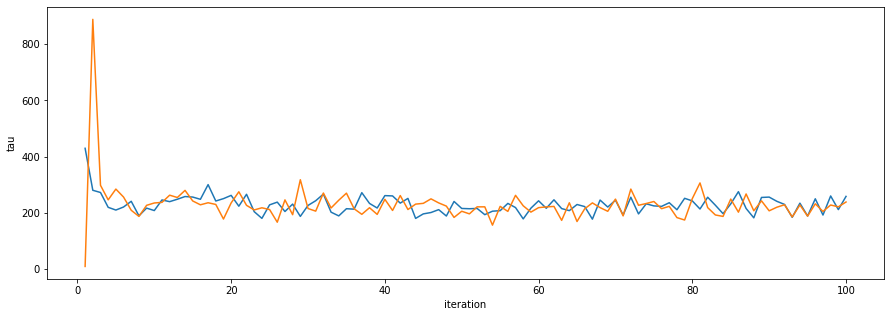

In [179]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'tau', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'tau', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

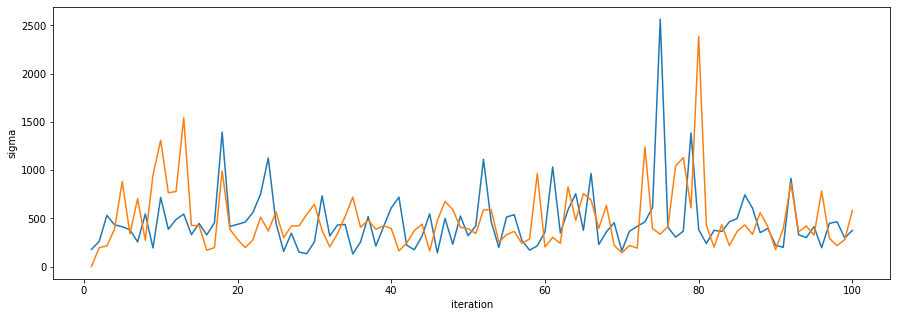

In [180]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'sigma', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'sigma', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

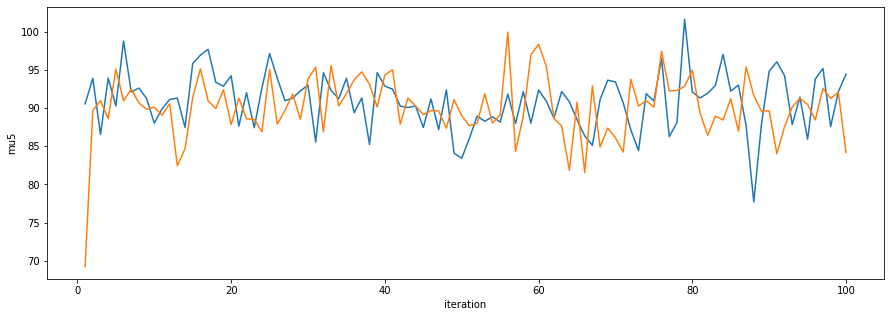

In [181]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'mu5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'mu5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

In [182]:
def coupled_gibbs(df, mu_init1, mu0_init1, tau_init1, sigma_init1, mu_init2, mu0_init2, tau_init2, sigma_init2, numsamp, lag = 1):
    mu_samps1 = np.zeros((numsamp, 10))
    mu0_samps1 = np.zeros(numsamp)
    tau_samps1 = np.zeros(numsamp)
    sigma_samps1 = np.zeros(numsamp)
    
    mu_samps2 = np.zeros((numsamp - lag, 10))
    mu0_samps2 = np.zeros(numsamp - lag)
    tau_samps2 = np.zeros(numsamp - lag)
    sigma_samps2 = np.zeros(numsamp - lag)
    
    mu_samps1[0] = mu_init1
    mu0_samps1[0] = mu0_init1
    tau_samps1[0] = tau_init1
    sigma_samps1[0] = sigma_init1
    
    mu_samps2[0] = mu_init2
    mu0_samps2[0] = mu0_init2
    tau_samps2[0] = tau_init2
    sigma_samps2[0] = sigma_init2
    
    mu0_cnt = 0
    tau_cnt = 0
    sigma_cnt = 0
    mu_cnt = np.zeros(10)
    
    converge = False
    
    for i in range(1, numsamp):
        mu0_samps1[i] = np.random.normal(np.mean(mu_samps1[i - 1]), np.sqrt(tau_samps1[i - 1]/10))
        tau_samps1[i] = scipy.stats.invgamma.rvs(a = 9/2, scale = np.sum(np.power(mu_samps1[i - 1] - mu0_samps1[i], 2)) / 2)
        sigma_samps1[i] = scipy.stats.invgamma.rvs(a = 75, scale = np.sum(np.sum(np.power(df - mu_samps1[i - 1], 2))) / 2)

        mean1 = 15 * df.mean(axis = 0).to_numpy() / sigma_samps1[i] + mu0_samps1[i] / tau_samps1[i]
        variance1 = 15 / sigma_samps1[i] + 1 / tau_samps1[i]
        mu_samps1[i] = np.random.normal(mean1 / variance1, np.sqrt(1 / variance1), 10)
        
        if lag < i:                
            mu0_samps2[i - lag], mu0ind = sample_couple(mu0_samps1[i],
                                        lambda : np.random.normal(np.mean(mu_samps2[i - lag - 1]), np.sqrt(tau_samps2[i - lag - 1]/10)),
                                        lambda x1: scipy.stats.norm.pdf(x1, np.mean(mu_samps1[i - 1]), np.sqrt(tau_samps1[i - 1]/10)),
                                        lambda x2: scipy.stats.norm.pdf(x2, np.mean(mu_samps2[i - lag - 1]), np.sqrt(tau_samps2[i - lag - 1]/10))
                                        )
            if mu0ind == 0:
                mu0_cnt = 0
            else:
                mu0_cnt += 1
                
            tau_samps2[i - lag], tauind = sample_couple(tau_samps1[i],
                                        lambda : scipy.stats.invgamma.rvs(9/2, np.sum(np.power(mu_samps2[i - lag - 1] - mu0_samps2[i - lag], 2)) / 2),
                                        lambda x1: scipy.stats.invgamma.pdf(x1, 9/2, np.sum(np.power(mu_samps1[i - 1] - mu0_samps1[i], 2)) / 2),
                                        lambda x2: scipy.stats.invgamma.pdf(x2, 9/2, np.sum(np.power(mu_samps2[i - lag - 1] - mu0_samps2[i - lag], 2)) / 2)
                                        )
            if tauind == 0:
                tau_cnt = 0
            else:
                tau_cnt += 1

            sigma_samps2[i  - lag], sigmaind = sample_couple(sigma_samps1[i],
                                        lambda : scipy.stats.invgamma.rvs(a = 75, scale = np.sum(np.sum(np.power(df - mu_samps2[i - lag - 1], 2))) / 2),
                                        lambda x1: scipy.stats.invgamma.pdf(x1, a = 75, scale = np.sum(np.sum(np.power(df - mu_samps1[i - 1], 2))) / 2),
                                        lambda x2: scipy.stats.invgamma.pdf(x2, a = 75, scale = np.sum(np.sum(np.power(df - mu_samps2[i - lag - 1], 2))) / 2)
                                        )
            if sigmaind == 0:
                sigma_cnt = 0
            else:
                sigma_cnt += 1
                
            mean2 = 15 * df.mean(axis = 0).to_numpy() / sigma_samps2[i - lag] + mu0_samps2[i - lag] / tau_samps2[i - lag]
            variance2 = 15 / sigma_samps2[i - lag] + 1 / tau_samps2[i - lag]
            
            mu_prop2 = np.zeros(10)
            for j in range(len(mu_prop2)):
                mu_prop2[j], muind = sample_couple(mu_samps1[i, j],
                                         lambda : np.random.normal(mean2[j] / variance2, np.sqrt(1 / variance2)),
                                         lambda x1: scipy.stats.norm.pdf(x1, mean1[j] / variance1, np.sqrt(1 / variance1)),
                                         lambda x2: scipy.stats.norm.pdf(x2, mean2[j] / variance2, np.sqrt(1 / variance2))
                                        )
                if muind == 0:
                    mu_cnt[j] = 0
                else:
                    mu_cnt[j] += 1
                    
            mu_samps2[i - lag] = mu_prop2
            
        if mu0_cnt > 20 and tau_cnt > 20 and sigma_cnt > 20 and all(mu_cnt > 20):
            if not converge:
                print(i)
                converge = True
                
    if not converge:
        print("did not converge")
                
    return mu_samps1, mu0_samps1, tau_samps1, sigma_samps1, mu_samps2, mu0_samps2, tau_samps2, sigma_samps2
    
    

In [183]:
mu0_init1 = 300
sigma_init1 = 200
tau_init1 = 150

mean1 = 15 * df.mean(axis = 0) / 200 + 300 / 150
variance1 = 15 / 200 + 1 / 150
mu_init1 = np.random.normal(mean1 / variance1, np.sqrt(1 / variance1), 10)

mu0_init2 = 5
sigma_init2 = 10
tau_init2 = 2

mean2 = 15 * df.mean(axis = 0) / 10 + 5 / 2
variance2 = 15 / 10 + 1 / 2
mu_init2 = np.random.normal(mean2 / variance2, np.sqrt(1 / variance2), 10)

mu_samps1, mu0_samps1, tau_samps1, sigma_samps1, mu_samps2, mu0_samps2, tau_samps2, sigma_samps2 = coupled_gibbs(df, mu_init1, mu0_init1, tau_init1, sigma_init1, mu_init2, mu0_init2, tau_init2, sigma_init2, 150, lag = 1)


23


In [184]:
chain1_df = pd.DataFrame(np.vstack((np.linspace(1, 100, 100), mu0_samps1[1:101], sigma_samps1[1:101], tau_samps1[1:101], mu_samps1[1:101].T)).T, columns = ('iteration', 'mu0', 'tau', 'sigma', 'mu1', 'mu2', 'mu3', 'mu4', 'mu5', 'mu6', 'mu7', 'mu8', 'mu9', 'mu10'))
chain2_df = pd.DataFrame(np.vstack((np.linspace(1, 100, 100), mu0_samps2[:100], sigma_samps2[:100], tau_samps2[:100], mu_samps2[:100].T)).T, columns = ('iteration', 'mu0', 'tau', 'sigma', 'mu1', 'mu2', 'mu3', 'mu4', 'mu5', 'mu6', 'mu7', 'mu8', 'mu9', 'mu10'))

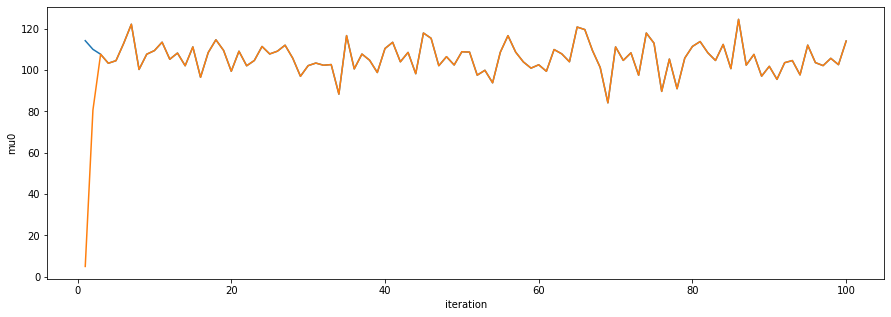

In [185]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'mu0', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'mu0', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

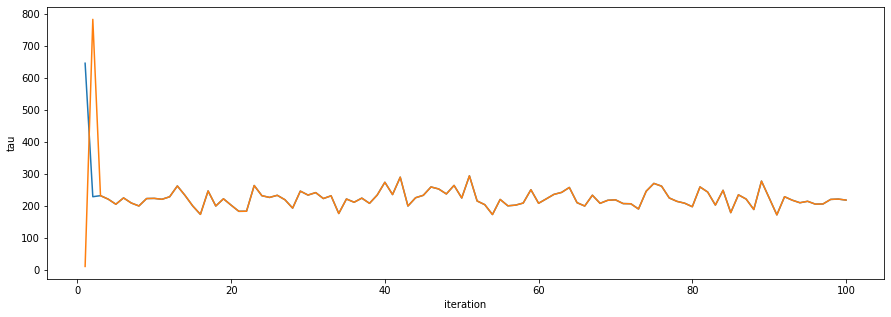

In [186]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'tau', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'tau', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

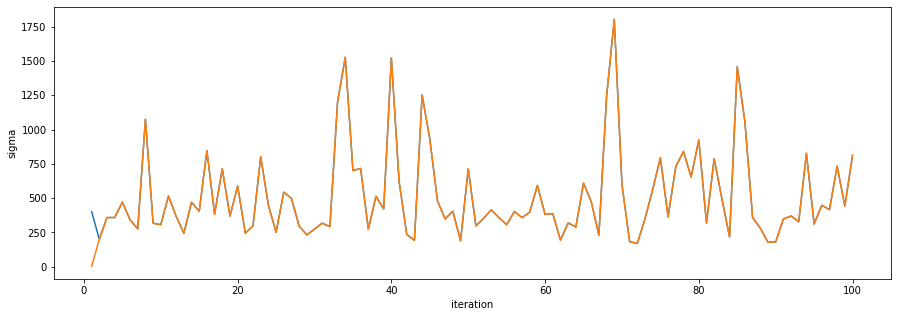

In [187]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'sigma', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'sigma', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

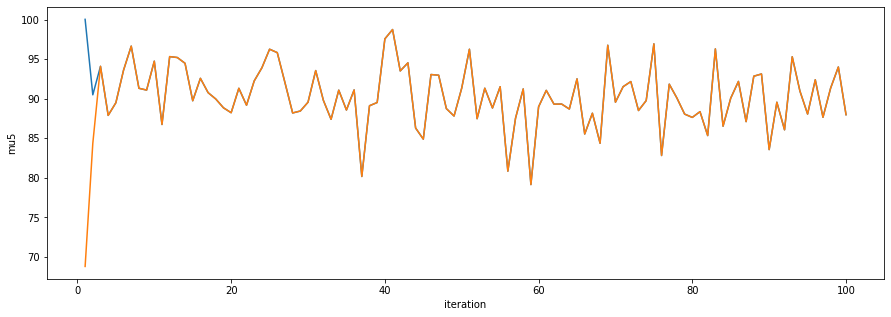

In [188]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'mu5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'mu5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

# Food Delivery Data

identifying busy vs non-busy food delivery days in a month

$$y_t \sim \begin{cases}Pois(\lambda_0), & X_t = 0\\Pois(\lambda_1), & X_t = 1\end{cases}$$

$$X_t \sim Bern(\alpha)$$

$$p(\alpha, \lambda_0, \lambda_1) \propto 1$$

Poisson Mixture Model

In [213]:
data3 = pd.read_csv("/Users/brianxiang/Downloads/data.final.2024.Q4.csv", sep = ' ')

## Standard

In [198]:
def theta(y, alpha, lambda1, lambda0, pos = True):
    p = alpha * np.power(lambda1, y) * np.exp(-lambda1)
    q =  (1 - alpha) * np.power(lambda0, y) * np.exp(-lambda0)
    if pos:
        return p/(p + q)
    else:
        return q/(p + q)

In [199]:
def sample_theta(y, alpha, lambda1, lambda0, n):
    u = np.random.uniform(0, 1, n)
    return (theta(y, alpha, lambda1, lambda0) >= u).astype(int)
        

In [200]:
def standard_gibbs(y, alpha_init1, lambda0_init1, lambda1_init1, X_init1, alpha_init2, lambda0_init2, lambda1_init2, X_init2, numsamp):
    alpha_samps1 = np.zeros(numsamp)
    lambda0_samps1 = np.zeros(numsamp)
    lambda1_samps1 = np.zeros(numsamp)
    X_samps1 = np.zeros((numsamp, 30))
    
    alpha_samps1[0] = alpha_init1
    lambda0_samps1[0] = lambda0_init1
    lambda1_samps1[0] = lambda1_init1
    X_samps1[0] = X_init1
    
    alpha_samps2 = np.zeros(numsamp)
    lambda0_samps2 = np.zeros(numsamp)
    lambda1_samps2 = np.zeros(numsamp)
    X_samps2 = np.zeros((numsamp, 30))
    
    alpha_samps2[0] = alpha_init2
    lambda0_samps2[0] = lambda0_init2
    lambda1_samps2[0] = lambda1_init2
    X_samps2[0] = X_init2
        
    for i in range(1, numsamp):
        X_samps1[i] = sample_theta(y, alpha_samps1[i - 1], lambda1_samps1[i - 1], lambda0_samps1[i - 1], 30)
        alpha_samps1[i] = np.random.beta(1 + np.sum(X_samps1[i]), 31 - np.sum(X_samps1[i]))
        lambda0_samps1[i] = np.random.gamma(30 * np.mean(y) + 1 - np.sum(y * X_samps1[i]), scale = 1 / (30 - np.sum(X_samps1[i])))
        lambda1_samps1[i] = np.random.gamma(1 + np.sum(y * X_samps1[i]), 1 / np.sum(X_samps1[i]))
        
        X_samps2[i] = sample_theta(y, alpha_samps2[i - 1], lambda1_samps2[i - 1], lambda0_samps2[i - 1], 30)
        alpha_samps2[i] = np.random.beta(1 + np.sum(X_samps2[i]), 31 - np.sum(X_samps2[i]))
        lambda0_samps2[i] = np.random.gamma(30 * np.mean(y) + 1 - np.sum(y * X_samps2[i]), scale = 1 / (30 - np.sum(X_samps2[i])))
        lambda1_samps2[i] = np.random.gamma(1 + np.sum(y * X_samps2[i]), 1 / np.sum(X_samps2[i]))
        
            
    return alpha_samps1, lambda0_samps1, lambda1_samps1, X_samps1, alpha_samps2, lambda0_samps2, lambda1_samps2, X_samps2
    

In [201]:
y = data3['Y'].to_numpy()

alpha_samps1, lambda0_samps1, lambda1_samps1, X_samps1, alpha_samps2, lambda0_samps2, lambda1_samps2, X_samps2 = standard_gibbs(y, 0.5, 1.5, 2, np.zeros(30), 0.2, 10, 50, np.zeros(30), 150)

In [202]:
chain1_df = pd.DataFrame(np.vstack((np.linspace(1, 100, 100), alpha_samps1[1:101], lambda0_samps1[1:101], lambda1_samps1[1:101])).T, columns = ('iteration', 'alpha', 'lambda0', 'lambda1'))
chain2_df = pd.DataFrame(np.vstack((np.linspace(1, 100, 100), alpha_samps2[:100], lambda0_samps2[:100], lambda1_samps2[:100])).T, columns = ('iteration', 'alpha', 'lambda0', 'lambda1'))

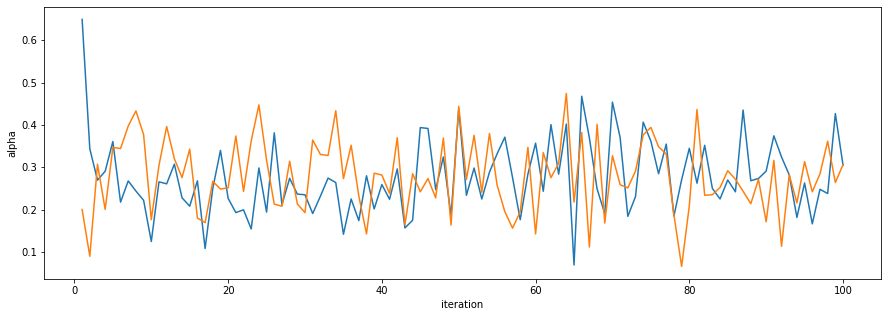

In [203]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

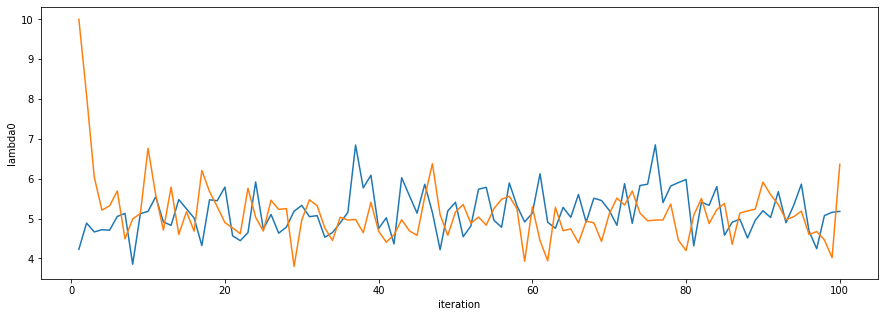

In [204]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'lambda0', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'lambda0', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

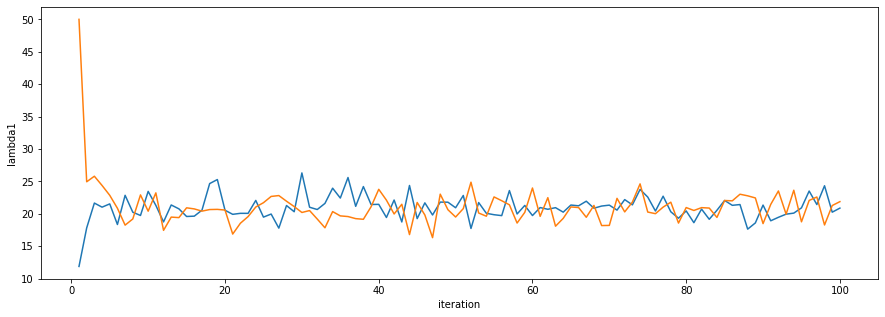

In [205]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'lambda1', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'lambda1', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

## Unbiased

In [125]:
# def sample_couple(x, samp_func, p, q):
#     wx = random.uniform(0, p(x))
#     if wx <= q(x):
#         return x, 1
#     else:
#         y_star = samp_func()
#         wy = random.uniform(0, q(y_star))
        
#         while wy <= p(y_star):
#             y_star = samp_func()
#             wy = random.uniform(0, q(y_star))
            
#         return y_star, 0

In [206]:
def coupled_gibbs(y, alpha_init1, lambda0_init1, lambda1_init1, X_init1, alpha_init2, lambda0_init2, lambda1_init2, X_init2, numsamp, lag = 1):
    alpha_samps1 = np.zeros(numsamp)
    lambda0_samps1 = np.zeros(numsamp)
    lambda1_samps1 = np.zeros(numsamp)
    X_samps1 = np.zeros((numsamp, 30))
    
    alpha_samps1[0] = alpha_init1
    lambda0_samps1[0] = lambda0_init1
    lambda1_samps1[0] = lambda1_init1
    X_samps1[0] = X_init1
    
    alpha_samps2 = np.zeros(numsamp - lag)
    lambda0_samps2 = np.zeros(numsamp - lag)
    lambda1_samps2 = np.zeros(numsamp - lag)
    X_samps2 = np.zeros((numsamp - lag, 30))
    
    alpha_samps2[0] = alpha_init2
    lambda0_samps2[0] = lambda0_init2
    lambda1_samps2[0] = lambda1_init2
    X_samps2[0] = X_init2
    
    alphacnt = 0
    lambda1cnt = 0
    lambda0cnt = 0
    Xcnt = np.zeros(30)
    
    converge = False
    
    for i in range(1, numsamp):
        X_prop1 = np.zeros(30)
        while all(X_prop1 == 0) or all(X_prop1 == 1):
           X_prop1 = sample_theta(y, alpha_samps1[i - 1], lambda1_samps1[i - 1], lambda0_samps1[i - 1], 30)
        X_samps1[i] = X_prop1
        alpha_samps1[i] = np.random.beta(1 + np.sum(X_samps1[i]), 31 - np.sum(X_samps1[i]))
        lambda0_samps1[i] = np.random.gamma(30 * np.mean(y) + 1 - np.sum(y * X_samps1[i]), scale = 1 / (30 - np.sum(X_samps1[i])))
        lambda1_samps1[i] = np.random.gamma(1 + np.sum(y * X_samps1[i]), 1 / np.sum(X_samps1[i]))
        
        if lag < i:
            X_prop2 = np.zeros(30)
#             Xtempcnt = np.zeros(30)
            while all(X_prop2 == 0) or all(X_prop2 == 1):
                for j in range(len(X_prop2)):
                    X_prop2[j], Xind = sample_couple(X_samps1[i, j],
                                               lambda : sample_theta(y[j], alpha_samps2[i - lag - 1], lambda1_samps2[i - lag - 1], lambda0_samps2[i - lag - 1], 1),
                                               lambda x1: theta(y[j], alpha_samps1[i - 1], lambda1_samps1[i - 1], lambda0_samps1[i - 1], pos = bool(x1)),
                                               lambda x2: theta(y[j], alpha_samps2[i - lag - 1], lambda1_samps2[i - lag - 1], lambda0_samps2[i - lag - 1], pos = bool(x2))
                                              )
#                     if Xind == 0:
#                         Xtempcnt[j] = 0
#                     else:
#                         Xtempcnt[j] = 1
                        
#             for j in range(len(Xtempcnt)):
#                 if Xtempcnt[j] == 0:
#                     Xcnt[j] = 0
#                 else:
#                     Xcnt[j] += Xtempcnt[j]
                
            X_samps2[i - lag] = X_prop2
            
            alpha_samps2[i - lag], alphaind = sample_couple(alpha_samps1[i],
                                           lambda : np.random.beta(1 + np.sum(X_samps2[i - lag]), 31 - np.sum(X_samps2[i - lag])),
                                           lambda x1: scipy.stats.beta.pdf(x1, 1 + np.sum(X_samps1[i]), 31 - np.sum(X_samps1[i])),
                                           lambda x2: scipy.stats.beta.pdf(x2, 1 + np.sum(X_samps2[i - lag]), 31 - np.sum(X_samps2[i - lag]))
                                          )
            if alphaind == 0:
                alphacnt = 0
            else:
                alphacnt += alphaind
            
            lambda0_samps2[i - lag], lambda0ind = sample_couple(lambda0_samps1[i],
                                           lambda : np.random.gamma(30 * np.mean(y) + 1 - np.sum(y * X_samps2[i - lag]), scale = 1 / (30 - np.sum(X_samps2[i - lag]))),
                                           lambda x1: scipy.stats.gamma.pdf(x1, 30 * np.mean(y) + 1 - np.sum(y * X_samps1[i]), scale = 1 / (30 - np.sum(X_samps1[i]))),
                                           lambda x2: scipy.stats.gamma.pdf(x2, 1 + 30 * np.mean(y) + 1 - np.sum(y * X_samps2[i - lag]), scale = 1 / (30 - np.sum(X_samps2[i - lag])))
                                          )
            if lambda0ind == 0:
                lambda0cnt = 0
            else:
                lambda0cnt += lambda0ind
                
            lambda1_samps2[i - lag], lambda1ind = sample_couple(lambda1_samps1[i],
                                           lambda : np.random.gamma(1 + np.sum(y * X_samps2[i - lag]), scale = 1 / np.sum(X_samps2[i - lag])),
                                           lambda x1: scipy.stats.gamma.pdf(x1, 1 + np.sum(y * X_samps1[i]), scale = 1 / np.sum(X_samps1[i])),
                                           lambda x2: scipy.stats.gamma.pdf(x2, 1 + np.sum(y * X_samps2[i - lag]), scale = 1 / np.sum(X_samps2[i - lag]))
                                          )
            
            if lambda1ind == 0:
                lambda1cnt = 0
            else:
                lambda1cnt += lambda1ind
            
        if alphacnt > 20 and lambda0cnt > 20 and lambda1cnt > 20:
            if not converge:
                print(i)
                converge = True
    if not converge:
        print("Did not converge")
            
    return alpha_samps1, lambda0_samps1, lambda1_samps1, X_samps1, alpha_samps2, lambda0_samps2, lambda1_samps2, X_samps2
    

In [207]:
y = data3['Y'].to_numpy()

alpha_samps1, lambda0_samps1, lambda1_samps1, X_samps1, alpha_samps2, lambda0_samps2, lambda1_samps2, X_samps2 = coupled_gibbs(y, 0.5, 1.5, 2, np.zeros(30), 0.2, 10, 50, np.zeros(30), 150)

33


In [208]:
chain1_df = pd.DataFrame(np.vstack((np.linspace(1, 100, 100), alpha_samps1[1:101], lambda0_samps1[1:101], lambda1_samps1[1:101])).T, columns = ('iteration', 'alpha', 'lambda0', 'lambda1'))
chain2_df = pd.DataFrame(np.vstack((np.linspace(1, 100, 100), alpha_samps2[:100], lambda0_samps2[:100], lambda1_samps2[:100])).T, columns = ('iteration', 'alpha', 'lambda0', 'lambda1'))

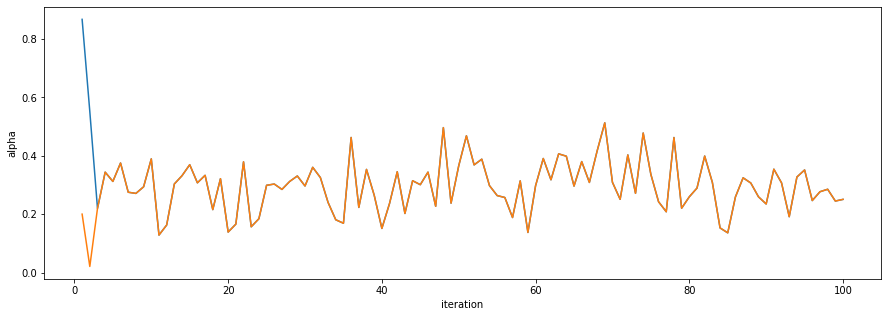

In [209]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

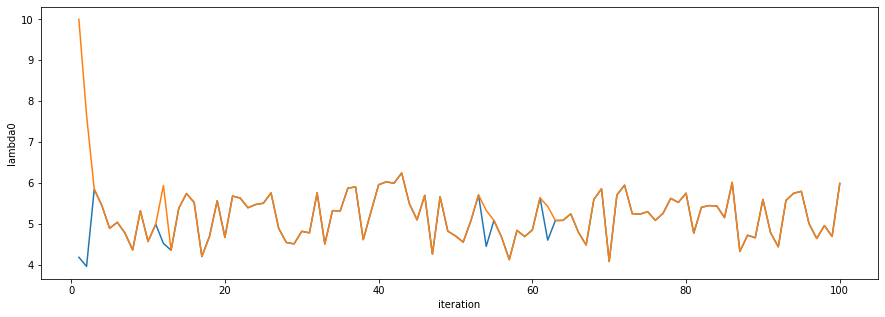

In [210]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'lambda0', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'lambda0', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

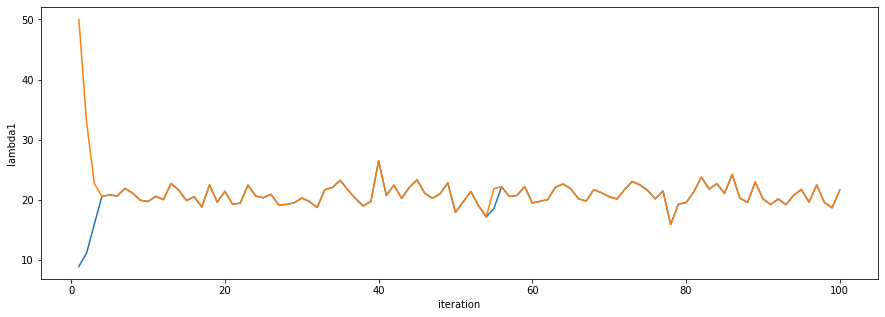

In [211]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'lambda1', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'lambda1', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

# Total Traffic Data

Determine the amount of traffic on each street.

$$y_i \sim Poisson(\theta_i)$$
$$\theta_i \sim Gamma(\alpha, \beta)$$
$$p(\alpha, \beta) \propto 1$$

Poisson-Gamma HM

In [214]:
data4 = pd.read_table("/Users/brianxiang/Downloads/bicycles-1.txt", sep = '\s+', header = 0)

In [114]:
y = data4.iloc[2, 2:12].astype(int).to_numpy() + data4.iloc[2, 12:22].astype(int).to_numpy()

In [121]:
def logabt(data, alpha, beta, theta):
    if alpha <= 0 or beta <= 0 or any(theta) <= 0:
        return -float("inf")
    else:
        n = len(data)
        return alpha * n * np.log(beta) - n * np.log(scipy.special.gamma(alpha)) + np.sum((alpha + data - 1) * np.log(theta)) - np.sum((beta + 1) * np.log(theta))

In [236]:
def loga(y, alpha, beta, theta):
    if alpha <= 0:
        return -float("inf")
    else:
        n = len(y)
        return alpha * n * np.log(beta) - n * np.log(scipy.special.gamma(alpha)) + alpha * np.sum(np.log(theta))

In [174]:
def standard_mh(y, alpha_init1, beta_init1, theta_init1, alpha_init2, beta_init2, theta_init2, tuning, numsamp):
    alpha_samps1 = np.zeros(numsamp)
    beta_samps1 = np.zeros(numsamp)
    theta_samps1 = np.zeros((numsamp, len(y)))
    
    alpha_samps1[0] = alpha_init1
    beta_samps1[0] = beta_init1
    theta_samps1[0] = theta_init1
    
    alpha_samps2 = np.zeros(numsamp)
    beta_samps2 = np.zeros(numsamp)
    theta_samps2 = np.zeros((numsamp, len(y)))
    
    alpha_samps2[0] = alpha_init2
    beta_samps2[0] = beta_init2
    theta_samps2[0] = theta_init2
    
    for i in range(1, numsamp):
        theta_prop1 = np.random.normal(theta_samps1[i - 1], 55, len(y))
        beta_prop1 = np.random.normal(beta_samps1[i - 1], tuning)
        alpha_prop1 = np.random.normal(alpha_samps1[i - 1], tuning)
        
        logu1 = random.uniform(0, 1)
        logr1 = logabt(y, alpha_prop1, beta_prop1, theta_prop1) - logabt(y, alpha_samps1[i - 1], beta_samps1[i - 1], theta_samps1[i - 1])
        
        if logu1 <= logr1:
            alpha_samps1[i] = alpha_prop1
            beta_samps1[i] = beta_prop1
            theta_samps1[i] = theta_prop1
        else:
            alpha_samps1[i] = alpha_samps1[i - 1]
            beta_samps1[i] = beta_samps1[i - 1]
            theta_samps1[i] = theta_samps1[i - 1]
            
        theta_prop2 = np.random.normal(theta_samps2[i - 1], 55, len(y))
        beta_prop2 = np.random.normal(beta_samps2[i - 1], tuning)
        alpha_prop2 = np.random.normal(alpha_samps2[i - 1], tuning)
        
        logu2 = random.uniform(0, 1)
        logr2 = logabt(y, alpha_prop2, beta_prop2, theta_prop2) - logabt(y, alpha_samps2[i - 1], beta_samps2[i - 1], theta_samps2[i - 1])
        
        if logu2 <= logr2:
            alpha_samps2[i] = alpha_prop2
            beta_samps2[i] = beta_prop2
            theta_samps2[i] = theta_prop2
        else:
            alpha_samps2[i] = alpha_samps2[i - 1]
            beta_samps2[i] = beta_samps2[i - 1]
            theta_samps2[i] = theta_samps2[i - 1]
            
    return alpha_samps1, beta_samps1, theta_samps1, alpha_samps2, beta_samps2, theta_samps2

In [ ]:
def standard_mh(y, alpha_init1, beta_init1, theta_init1, alpha_init2, beta_init2, theta_init2, tuning, numsamp):
    alpha_samps1 = np.zeros(numsamp)
    beta_samps1 = np.zeros(numsamp)
    theta_samps1 = np.zeros((numsamp, len(y)))
    
    alpha_samps1[0] = alpha_init1
    beta_samps1[0] = beta_init1
    theta_samps1[0] = theta_init1
    
    alpha_samps2 = np.zeros(numsamp)
    beta_samps2 = np.zeros(numsamp)
    theta_samps2 = np.zeros((numsamp, len(y)))
    
    alpha_samps2[0] = alpha_init2
    beta_samps2[0] = beta_init2
    theta_samps2[0] = theta_init2
    
    for i in range(1, numsamp):
        theta_prop1 = np.random.gamma(alpha_samps1[i - 1] + y, scale = 1 / (beta_samps1[i - 1] + 1), size = len(y))
        theta_samps1[i] = theta_prop1
        
        beta_prop1 = np.random.gamma(alpha_samps1[i - 1] * len(y) + 1, scale = 1 / (np.sum(theta_samps1[i])))
        beta_samps1[i] = beta_prop1
    
        alpha_prop1 = np.random.normal(alpha_samps1[i - 1], tuning)
        alpha_samps1[i] = ar_prop(alpha_samps1[i - 1], alpha_prop1, lambda x: logabt(y, x, beta_samps1[i], theta_samps1[i]))
        
        theta_prop2 = np.random.gamma(alpha_samps2[i - 1] + y, scale = 1 / (beta_samps2[i - 1] + 1), size = len(y))
        theta_samps2[i] = theta_prop2
        
        beta_prop2 = np.random.gamma(alpha_samps2[i - 1] * len(y) + 1, scale = 1 / (np.sum(theta_samps2[i])))
        beta_samps2[i] = beta_prop2
    
        alpha_prop2 = np.random.normal(alpha_samps2[i - 1], tuning)
        alpha_samps2[i] = ar_prop(alpha_samps2[i - 1], alpha_prop2, lambda x: loga(y, x, beta_samps2[i], theta_samps2[i]))
        
    return alpha_samps1, beta_samps1, theta_samps1, alpha_samps2, beta_samps2, theta_samps2

In [181]:
alpha_init1 = 50
beta_init1 = 20
theta_init1 = np.random.gamma(50 + y, 21, len(y))

alpha_init2 = 15
beta_init2 = 30
theta_init2 = np.random.gamma(15 + y, 31, len(y))

alpha_samps1, beta_samps1, theta_samps1, alpha_samps2, beta_samps2, theta_samps2 = standard_mh(y, alpha_init1, beta_init1, theta_init1, alpha_init2, beta_init2, theta_init2, tuning = 0.25, numsamp = 150000)

In [186]:
chain1_df = pd.DataFrame(np.vstack((np.linspace(1, 140000, 140000), alpha_samps1[1:140001], beta_samps1[1:140001], theta_samps1[1:140001].T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10'))
chain2_df = pd.DataFrame(np.vstack((np.linspace(1, 140000, 140000), alpha_samps2[:140000], beta_samps2[:140000], theta_samps2[:140000].T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10'))

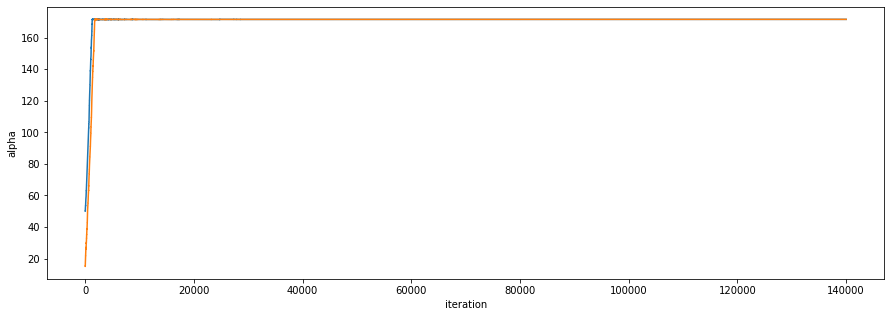

In [187]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

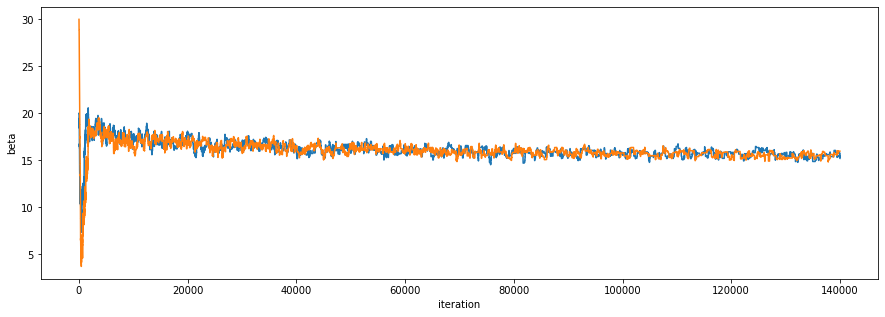

In [188]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

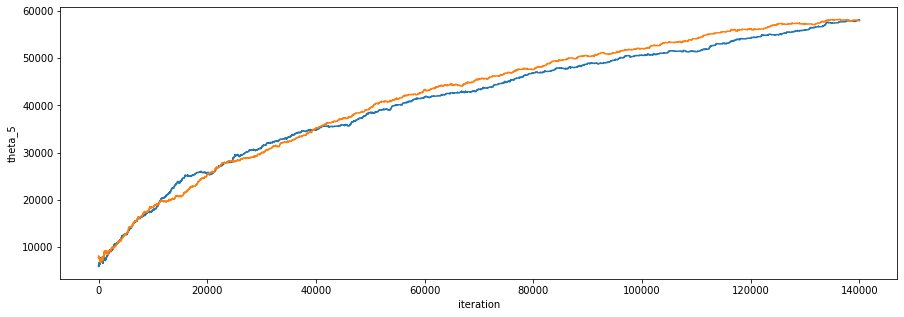

In [189]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta_5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta_5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

In [247]:
def unbiased_mh(y, alpha_init1, beta_init1, theta_init1, alpha_init2, beta_init2, theta_init2, tuning, numsamp, lag = 1):
    alpha_samps1 = np.zeros(numsamp)
    beta_samps1 = np.zeros(numsamp)
    theta_samps1 = np.zeros((numsamp, len(y)))
    
    alpha_samps1[0] = alpha_init1
    beta_samps1[0] = beta_init1
    theta_samps1[0] = theta_init1
    
    alpha_samps2 = np.zeros(numsamp - lag)
    beta_samps2 = np.zeros(numsamp - lag)
    theta_samps2 = np.zeros((numsamp - lag, len(y)))
    
    alpha_samps2[0] = alpha_init2
    beta_samps2[0] = beta_init2
    theta_samps2[0] = theta_init2
    
    alpha_cnt = 0
    beta_cnt = 0
    theta_cnt = np.zeros(len(y))
    
    converge = False
    
    for i in range(1, numsamp):
        theta_prop1 = np.random.gamma(alpha_samps1[i - 1] + y, scale = 1 / (beta_samps1[i - 1] + 1), size = len(y))
        theta_samps1[i] = theta_prop1
        
        beta_prop1 = np.random.gamma(alpha_samps1[i - 1] * len(y) + 1, scale = 1 / (np.sum(theta_samps1[i])))
        beta_samps1[i] = beta_prop1
    
        alpha_prop1 = np.random.normal(alpha_samps1[i - 1], tuning)
        alpha_samps1[i] = ar_prop(alpha_samps1[i - 1], alpha_prop1, lambda x: loga(y, x, beta_samps1[i], theta_samps1[i]))
        
        if lag < i:
            theta_prop2 = np.zeros(len(y))
            for j in range(len(y)):
                theta_prop2[j], tind = sample_couple(theta_prop1[j], 
                                                lambda : np.random.gamma(alpha_samps2[i - lag - 1] + y[j], scale = 1 / (beta_samps2[i - lag - 1] + 1)),
                                                lambda x1: scipy.stats.gamma.pdf(x1, alpha_samps1[i - 1] + y[j], scale = 1 / (beta_samps1[i - 1] + 1)),
                                                lambda x2: scipy.stats.gamma.pdf(x2, alpha_samps2[i - lag - 1] + y[j], scale = 1 / (beta_samps2[i - lag - 1] + 1))
                                                )
                
                if tind == 0:
                    theta_cnt[j] = 0
                else:
                    theta_cnt[j] += 1
                    
            theta_samps2[i - lag] = theta_prop2
            
            beta_samps2[i - lag], bind = sample_couple(beta_prop1,
                                            lambda : np.random.gamma(alpha_samps2[i - lag - 1] * len(y) + 1, scale = 1 / (np.sum(theta_samps2[i - lag]))),
                                            lambda x1: scipy.stats.gamma.pdf(x1, alpha_samps1[i - 1] * len(y) + 1, scale = 1 / (np.sum(theta_samps1[i]))),
                                            lambda x2: scipy.stats.gamma.pdf(x2, alpha_samps2[i - lag - 1] * len(y) + 1, scale = 1 / (np.sum(theta_samps2[i - lag])))
                                            )
            if bind == 0:
                beta_cnt = 0
            else:
                beta_cnt += 1
                
            alpha_prop2, aind = sample_couple(alpha_prop1,
                                    lambda : np.random.normal(alpha_samps2[i - lag - 1], tuning),
                                    lambda x1: scipy.stats.norm.pdf(x1, alpha_samps1[i - 1], tuning),
                                    lambda x2: scipy.stats.norm.pdf(x2, alpha_samps2[i - lag - 1], tuning)
                                    )
            alpha_samps2[i - lag] = ar_prop(alpha_samps2[i - lag - 1], alpha_prop2, lambda x: loga(y, x, beta_samps2[i - lag], theta_samps2[i - lag]))
            if aind == 0:
                alpha_cnt = 0
            else:
                alpha_cnt += 1
        if alpha_cnt > 20 and beta_cnt > 20 and all(theta_cnt > 20):
            if not converge:
                print(i)
                converge = True
    if not converge:
        print("Did not converge")
        
    return alpha_samps1, beta_samps1, theta_samps1, alpha_samps2, beta_samps2, theta_samps2

In [248]:
alpha_init1 = 50
beta_init1 = 20
theta_init1 = np.random.gamma(50 + y, 21, len(y))

alpha_init2 = 15
beta_init2 = 30
theta_init2 = np.random.gamma(15 + y, 31, len(y))

alpha_samps1, beta_samps1, theta_samps1, alpha_samps2, beta_samps2, theta_samps2 = unbiased_mh(y, alpha_init1, beta_init1, theta_init1, alpha_init2, beta_init2, theta_init2, tuning = 0.25, numsamp = 1500)

1217


In [249]:
chain1_df = pd.DataFrame(np.vstack((np.linspace(1, 1000, 1000), alpha_samps1[1:1001], beta_samps1[1:1001], theta_samps1[1:1001].T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10'))
chain2_df = pd.DataFrame(np.vstack((np.linspace(1, 1000, 1000), alpha_samps2[:1000], beta_samps2[:1000], theta_samps2[:1000].T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10'))

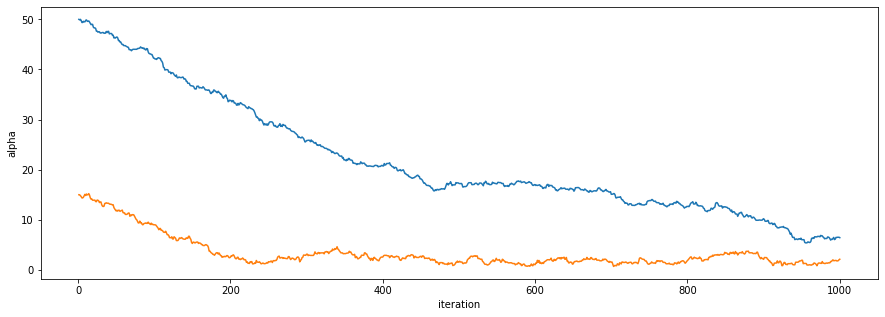

In [250]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

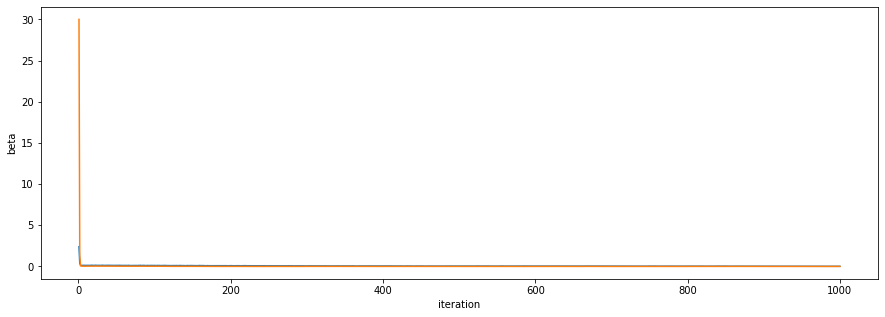

In [251]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

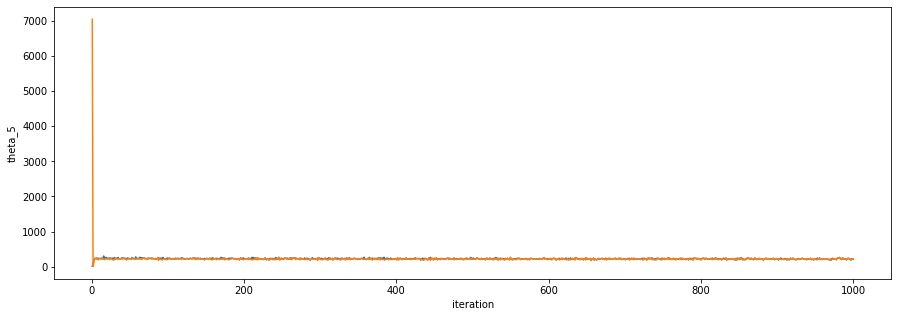

In [252]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta_5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta_5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

# Unbiased Method 1

Sampling joint posterior

In [3]:
def ar(prev, prop, crit, log_pdf):
    log_r = log_pdf(prop) - log_pdf(prev)
    if crit <= log_r:
        return prop
    else:
        return prev

In [4]:
def sample_couple(prev_x, prev_y, tuning):
    log_p = lambda z: scipy.stats.multivariate_normal.logpdf(z, prev_x, tuning * np.ones(len(prev_x)))
    log_q = lambda z: scipy.stats.multivariate_normal.logpdf(z, prev_y, tuning * np.ones(len(prev_y)))
    
    x_prop = scipy.stats.multivariate_normal.rvs(prev_x, tuning * np.ones(len(prev_x)))
    
    if np.log(random.uniform(0, 1)) <= log_q(x_prop) - log_p(x_prop):
        return x_prop, x_prop
    else:
        y_prop = scipy.stats.multivariate_normal.rvs(prev_y, tuning * np.ones(len(prev_y)))
        while np.log(random.uniform(0, 1)) <= log_p(y_prop) - log_q(y_prop):
            y_prop = scipy.stats.multivariate_normal.rvs(prev_y, tuning * np.ones(len(prev_y)))
            
        return x_prop, y_prop


In [104]:
def standard_metropolis(data, x_init, y_init, logpdf_fun, tuning, k = 100, lag = 1):
    params_x = [np.array(x_init)]
    params_y = [np.array(y_init)]
    
    iteration = 0
    
    logpdf = lambda z: logpdf_fun(data, z)
    
    for i in range(100000):
        x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], tuning * np.ones(len(params_x[-1])))
        y_prop = scipy.stats.multivariate_normal.rvs(params_y[-1], tuning * np.ones(len(params_y[-1])))
        log_u = np.log(random.uniform(0, 1))
        params_x.append(ar(params_x[-1], x_prop, log_u, logpdf))
        params_y.append(ar(params_y[-1], y_prop, log_u, logpdf))

        iteration += 1
        
    print(iteration)
        
    return params_x, params_y, iteration
    

In [ ]:
def standard_metropolis(data, x_init, y_init, logpdf_fun, tuning, k = 100, lag = 1):
    params_x = [np.array(x_init)]
    params_y = [np.array(y_init)]
    
    iteration = 0
    
    logpdf = lambda z: logpdf_fun(data, z)
    
    for i in range(100000):
        x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], tuning * np.ones(len(params_x[-1])))
        y_prop = scipy.stats.multivariate_normal.rvs(params_y[-1], tuning * np.ones(len(params_y[-1])))
        log_u = np.log(random.uniform(0, 1))
        params_x.append(ar(params_x[-1], x_prop, log_u, logpdf))
        params_y.append(ar(params_y[-1], y_prop, log_u, logpdf))

        iteration += 1
        
    print(iteration)
        
    return params_x, params_y, iteration
    

In [190]:
def coupled_metropolis(data, x_init, y_init, logpdf_fun, tuning, k = 100, lag = 1):
    params_x = [np.array(x_init)]
    params_y = [np.array(y_init)]
    
    iteration = 0
    
    logpdf = lambda z: logpdf_fun(data, z)
    
    while not all(params_x[-1] == params_y[-1]):
        if lag <= iteration:
            x_prop, y_prop = sample_couple(params_x[-1], params_y[-1], tuning)
            log_u = np.log(random.uniform(0, 1))
            params_x.append(ar(params_x[-1], x_prop, log_u, logpdf))
            params_y.append(ar(params_y[-1], y_prop, log_u, logpdf))
        else:
            x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], tuning * np.ones(len(params_x[-1])))
            log_u = np.log(random.uniform(0, 1))
            params_x.append(ar(params_x[-1], x_prop, log_u, logpdf))
        
        iteration += 1
        
        if iteration == 10000000:
            break
        
    print(iteration)
    
    for i in range(k):
        x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], tuning * np.ones(len(params_x[-1])))
        logu = np.log(random.uniform(0, 1))
        temp = ar(params_x[-1], x_prop, logu, logpdf)
        params_x.append(temp)
        params_y.append(temp)
        
    return params_x, params_y, iteration
    

In [217]:
def log_pg(data, params):
    if any(params <= 0):
        return -float("inf")
    else:
        n = len(data)
        return params[0] * n * np.log(params[1]) - n * np.log(scipy.special.gamma(params[0])) + np.sum((params[0] + data - 1) * np.log(params[2:])) - np.sum((params[1] + 1) * np.log(params[2:]))

In [192]:
data = y

a_1 = 50
b_1 = 20
theta_1 = np.random.gamma(50 + y, 21, len(y))

a_2 = 15
b_2 = 30
theta_2 = np.random.gamma(15 + y, 31, len(y))

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params_x, params_y, iteration = coupled_metropolis(data, x_init, y_init, log_pg, tuning = np.array([0.3, 0.3] + [10] * len(y)))

KeyboardInterrupt: 

In [108]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

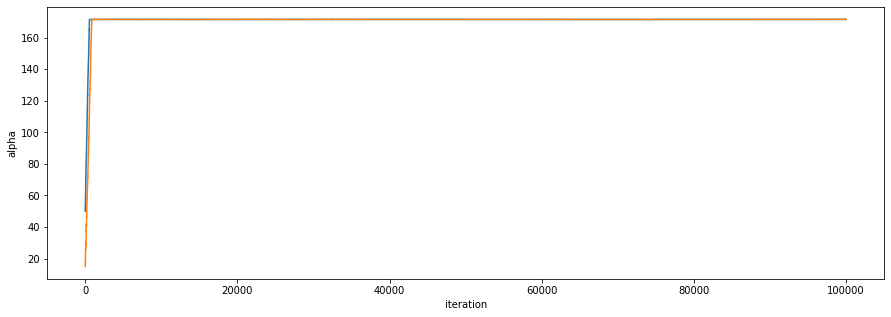

In [109]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

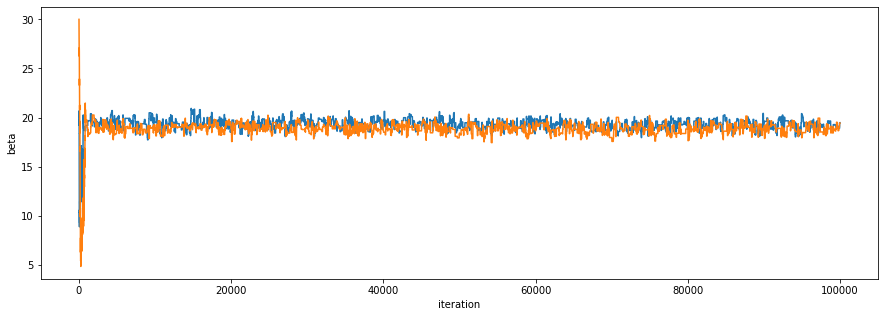

In [110]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

In [218]:
def log_bb(data, params):
    if any(params <= 0) or any(params[2:] > 1):
        return -float("inf")
    else:
        return -15 * np.log(scipy.special.beta(params[0], params[1])) + np.sum((data[0] + params[0] - 1) * np.log(params[2:])) + np.sum((data[1] - data[0] + params[1] - 1) * np.log(1 - params[2:]))

In [623]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [n, y]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params_x, params_y, iteration = coupled_metropolis(data, x_init, y_init, log_bb)

100000


In [624]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

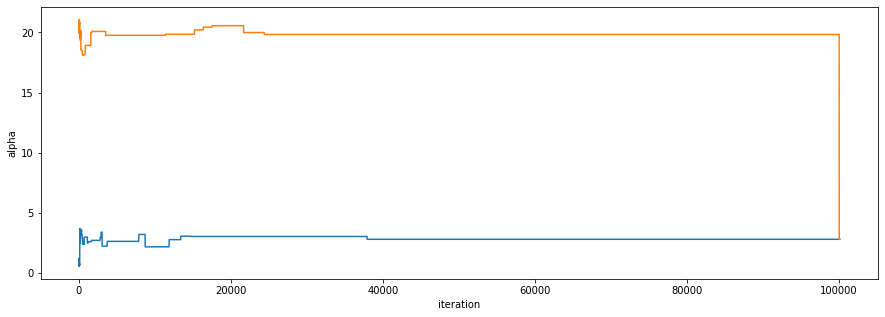

In [626]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

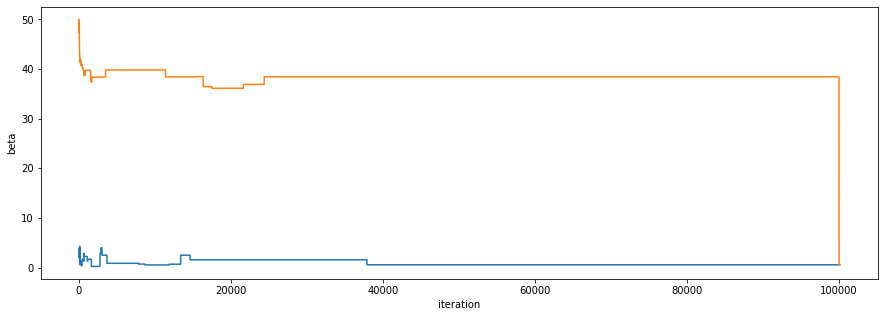

In [627]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

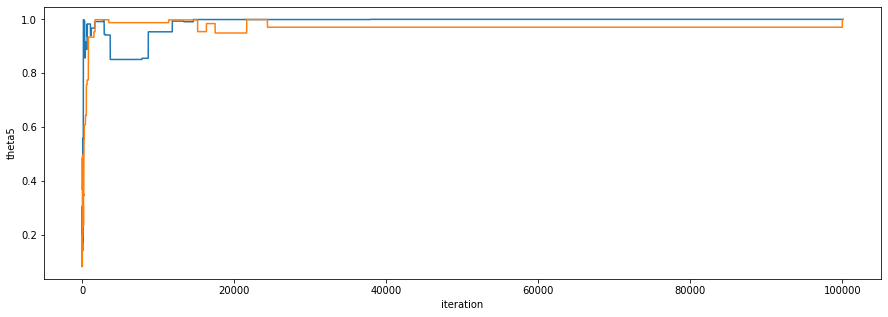

In [628]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

$$y_i \sim Pois(\theta_i)$$

$$\theta_i \sim Gamma(\alpha, \beta)$$

$$p(\alpha, \beta, \theta | y) = \prod(p(y_i | \theta_i) \cdot p(\theta_i | \alpha, \beta) \cdot p(\alpha, \beta) = $$

$$\prod \frac{\theta_i^{y_i}e^{-\theta_i}}{y_i!} \cdot \frac{\beta^{\alpha}}{\Gamma(\alpha)} \theta_i^{\alpha - 1}e^{-\beta\theta_i} \propto$$

$$\prod \frac{\beta^{\alpha}}{\Gamma(\alpha)} \theta_i^{\alpha + y_i - 1}e^{-(\beta + 1)\theta_i} $$

$$\ln p(\alpha, \beta, \theta | y) = \sum \alpha\ln(\beta) - \ln(\Gamma(\alpha)) + (\alpha + y_i - 1)\ln(\theta_i) -(\beta + 1)\theta_i $$

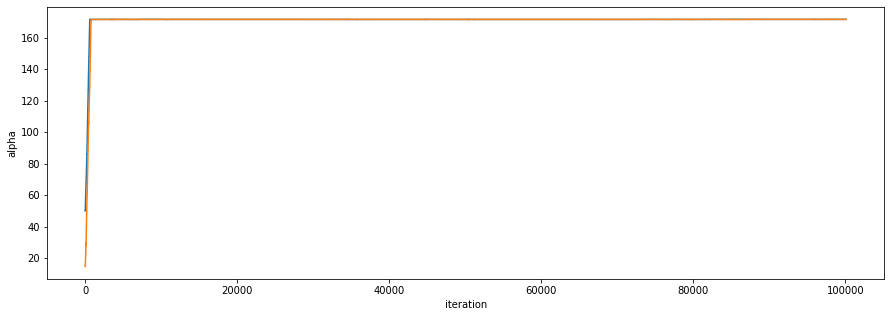

In [78]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

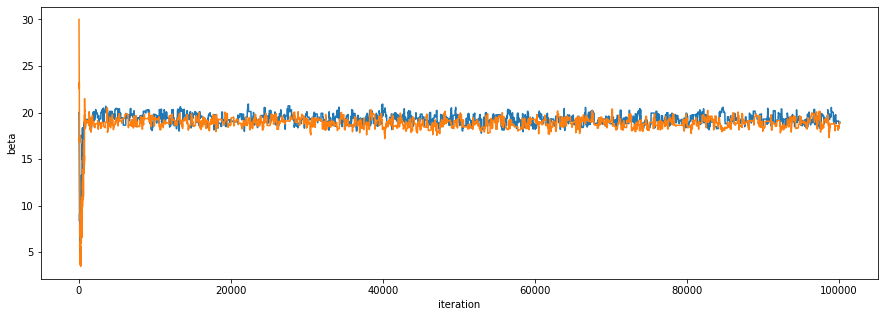

In [79]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

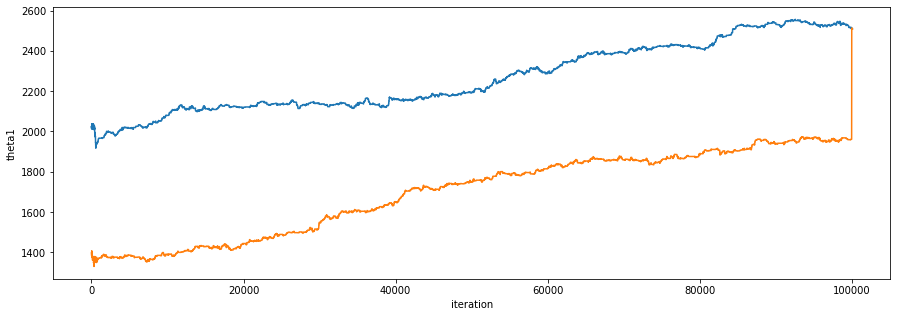

In [76]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta1', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta1', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

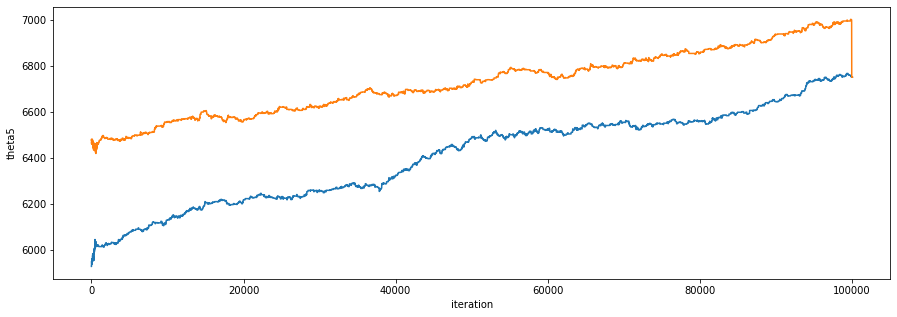

In [77]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

# Unbiased Method 2

Sampling joint posterior with multiple different posteriors

In [139]:
def ar(prev, prop, crit, log_pdf):
    log_r = log_pdf(prop) - log_pdf(prev)
    if crit <= log_r:
        return prop
    else:
        return prev

In [140]:
def sample_couple(prev_x, prev_y, tuning):
    log_p = lambda z: scipy.stats.multivariate_normal.logpdf(z, prev_x, tuning * np.ones(len(prev_x)))
    log_q = lambda z: scipy.stats.multivariate_normal.logpdf(z, prev_y, tuning * np.ones(len(prev_y)))
    
    x_prop = scipy.stats.multivariate_normal.rvs(prev_x, tuning * np.ones(len(prev_x)))
    
    if np.log(random.uniform(0, 1)) <= log_q(x_prop) - log_p(x_prop):
        return x_prop, x_prop
    else:
        y_prop = scipy.stats.multivariate_normal.rvs(prev_y, tuning * np.ones(len(prev_y)))
        while np.log(random.uniform(0, 1)) <= log_p(y_prop) - log_q(y_prop):
            y_prop = scipy.stats.multivariate_normal.rvs(prev_y, tuning * np.ones(len(prev_y)))
            
        return x_prop, y_prop

In [263]:
def coupled_metropolis2(data, x_init, y_init, logpdf_fun, tuning, k = 100, lag = 1):
    params_x = [np.array(x_init)]
    params_y = [np.array(y_init)]
    
    iteration = 0
    
    while not all(params_x[-1] == params_y[-1]):
        if lag <= iteration:
            x_prop, y_prop = sample_couple(params_x[-1], params_y[-1], tuning)

            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))
                x_prop[j] = ar(params_x[-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:]))))
                y_prop[j] = ar(params_y[-1][j], y_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_y[-1][:j], z, params_y[-1][j + 1:]))))
            
            params_x.append(x_prop)
            params_y.append(y_prop)

        else:
            x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], tuning * np.ones(len(params_x[-1])))
            
            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))
                x_prop[j] = ar(params_x[-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:]))))

            params_x.append(x_prop)
            
        iteration += 1
        if iteration == 10000:
            break
        
    print(iteration)
    
    for i in range(k):
        x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], tuning * np.ones(len(params_x[-1])))
        for j in range(len(x_prop)):
            logu = np.log(random.uniform(0, 1))
            x_prop[j] = ar(params_x[-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:]))))

        params_x.append(x_prop)
        params_y.append(x_prop)
        
    return params_x, params_y, iteration
    

In [264]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params_x, params_y, iteration = coupled_metropolis2(data, x_init, y_init, log_bb, tuning = np.array([0.3, 1.1] + [0.01] * 15), k = 1000)

460


In [265]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

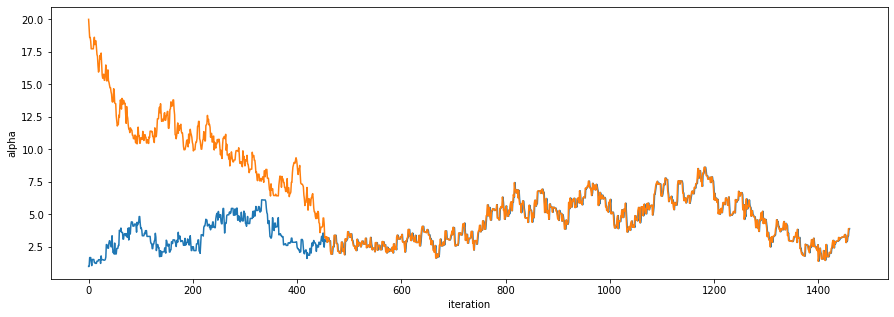

In [266]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

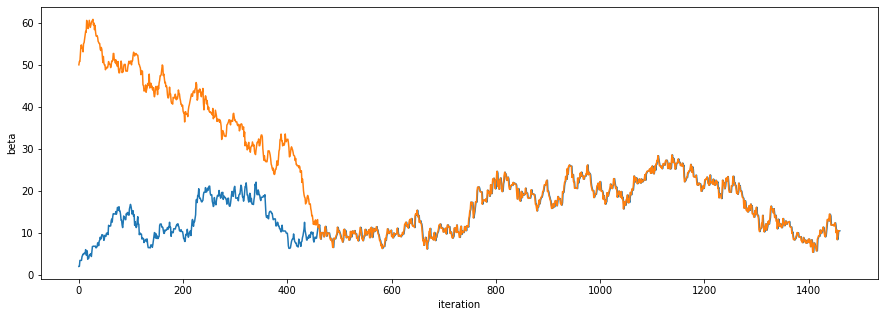

In [267]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

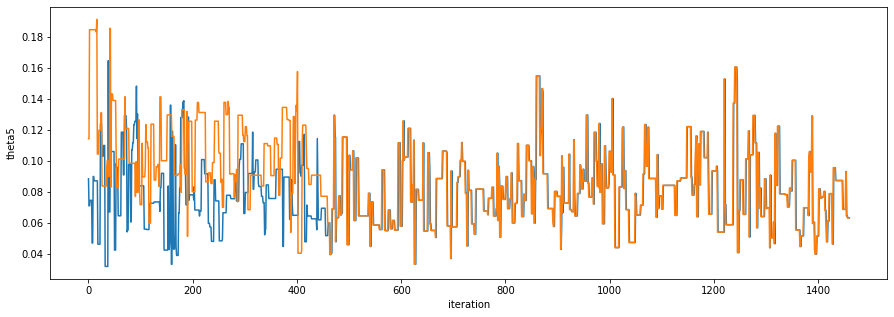

In [268]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

# Method 3

adding gibbs

In [141]:
def equality(px, py):
    if all (px[-1] == py[-1]):
        return True
    else:
        return False

In [142]:
def coupled_metropolis_gibbs(data, x_init, y_init, gibbs_vec, logpdf_fun, converge_fun, tuning, k = 100, lag = 1):
    params_x = [x_init]
    params_y = [y_init]
    
    iteration = 0
    
    while not converge_fun(params_x[-1], params_y[-1]):
        if lag <= iteration:
            temp_x = np.zeros(len(x_init), dtype = 'object')
            temp_y = np.zeros(len(x_init), dtype = 'object')

            for j in range(len(gibbs_vec)):
                temp_x[j] = gibbs_vec[j](data, params_x[-1])
                temp_y[j] = gibbs_vec[j](data, params_y[-1])

            x_prop, y_prop = sample_couple(params_x[-1][-1], params_y[-1][-1], tuning)

            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))
                x_prop[j] = ar(params_x[-1][-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][j + 1:]))], dtype = 'object')))
                y_prop[j] = ar(params_y[-1][-1][j], y_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_y[-1][:-1]) + [np.hstack((params_y[-1][-1][:j], z, params_y[-1][-1][j + 1:]))], dtype = 'object')))
            
            temp_x[-1] = x_prop
            temp_y[-1] = y_prop
            
            params_x.append(temp_x)
            params_y.append(temp_y)

        else:
            temp_x = np.zeros(len(x_init), dtype = 'object')
            for j in range(len(gibbs_vec)):
                temp_x[j] = gibbs_vec[j](data, params_x[-1])
            
            x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1][-1], tuning * np.ones(len(params_x[-1][-1])))

            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))                
                x_prop[j] = ar(params_x[-1][-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][j + 1:]))], dtype = 'object')))
            
            temp_x[-1] = x_prop
            
            params_x.append(temp_x)            
            
        iteration += 1
        if iteration == 10000:
            break
        
    print(iteration)
    
    for i in range(k):
        temp_x = np.zeros(len(x_init), dtype = 'object')
        for j in range(len(gibbs_vec)):
            temp_x[j] = gibbs_vec[j](data, params_x[-1])
            
        x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1][-1], tuning * np.ones(len(params_x[-1][-1])))

        for j in range(len(x_prop)):
            logu = np.log(random.uniform(0, 1))
            x_prop[j] = ar(params_x[-1][-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][j + 1:]))], dtype = 'object')))

        temp_x[-1] = x_prop

        params_x.append(temp_x)   
        params_y.append(temp_x)

    return params_x, params_y, iteration
    

In [143]:
def log_ab(data, params):
    if any(params[-1] <= 0):
        return -float("inf")
    else:
        return -15 * np.log(scipy.special.beta(params[-1][0], params[-1][1])) + params[-1][0] * np.sum(np.log(params[0])) + params[-1][1] * np.sum(np.log(1 - params[0]))

In [144]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.array((np.array(theta_1), np.array([a_1, b_1])), dtype = 'object')
y_init = np.array((np.array(theta_2), np.array([a_2, b_2])), dtype = 'object')

thetas = lambda data, params: np.random.beta(data[0] + params[-1][0], data[1] - data[0] + params[-1][1], 15)
gibbs_vec = [thetas]

params_x, params_y, iteration = coupled_metropolis_gibbs(data, x_init, y_init, gibbs_vec, log_ab, equality, tuning = np.array([0.3, 1.1]), k = 1000)

692


In [145]:
chain1_df = pd.DataFrame([np.hstack(x) for x in params_x], columns = ['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15', 'alpha', 'beta'])
chain2_df = pd.DataFrame([np.hstack(y) for y in params_y], columns = ['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15', 'alpha', 'beta'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

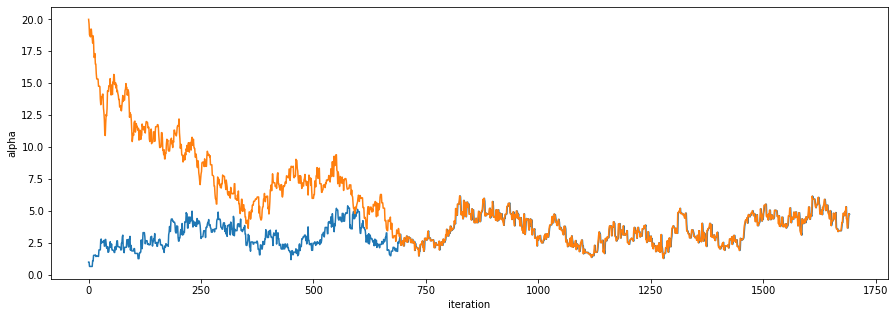

In [146]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

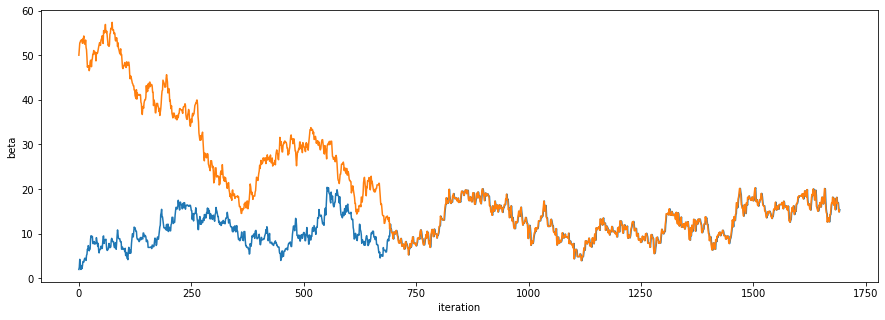

In [147]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

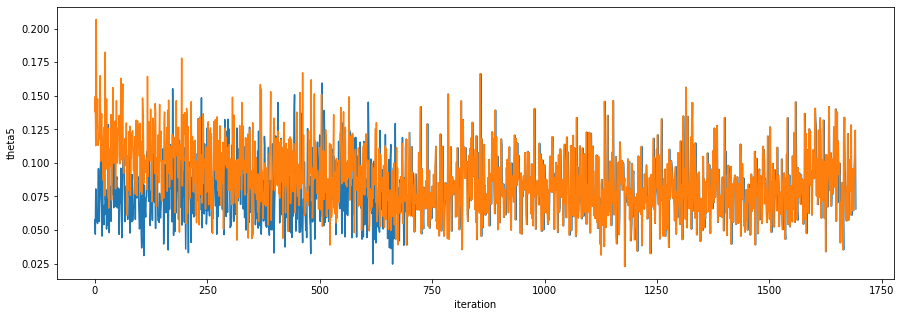

In [148]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

In [ ]:
#TODO:
#Create a wrapper,
#clean notebook

n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.array((np.array(theta_1), np.array([a_1, b_1])), dtype = 'object')
y_init = np.array((np.array(theta_2), np.array([a_2, b_2])), dtype = 'object')

thetas = lambda data, params: np.random.beta(data[0] + params[-1][0], data[1] - data[0] + params[-1][1], 15)
gibbs_vec = [thetas]

params_x, params_y, iteration = coupled_metropolis_gibbs(data, x_init, y_init, gibbs_vec, log_ab, equality, tuning = np.array([0.3, 1.1]), k = 1000)